### DMLP-pitmodel

Deterministic MLP pitmodel

test the new feature 'cur_cautionlaps'

base: MLP-pitmodel-plen2

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.dmlp import DMLPEstimator

INFO:root:Using GPU


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid, include_end = False):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
        
    # calc cur_cautionlaps
    # accumulate consecutive caution laps
    trackstatus = rec[COL_TRACKSTATUS,:]
    lapstatus = rec[COL_LAPSTATUS,:]
    
    #import pdb; pdb.set_trace()
    
    cur_cautionlaps = np.zeros_like(trackstatus)
    cautionlaps_acc = 0
    for idx in range(len(trackstatus)):
        if (trackstatus[idx] == 0) or (lapstatus[idx] == 1):
            #reset
            cautionlaps_acc = 0
        else:
            cautionlaps_acc += 1
            
        #save state
        cur_cautionlaps[idx] = cautionlaps_acc
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    if include_end:
        #rec = rec[:, ~np.isnan(rec[run_ts,:])]
        totallen = len(rec[COL_RANK, ~np.isnan(rec[COL_RANK,:])])
    else:
        totallen = pitstops[-1]
        
    # set the last stint target = 999, an invalid lap2nextpit
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx] if idx < pitstops[-1] else 999
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                        ,cur_cautionlaps[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018', include_end = False):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid, include_end= include_end)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [4]:
#
# caution_laps,pitage, cur_cautionlaps
#
_feature_cnt = 3
_feature_cnt = 2
featurecnt_str = 'withcurcautionlaps' if (_feature_cnt==3) else 'nocurcautionlaps'

In [5]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [6]:
_savedata_ = False
include_end = True
includeend_str = '-includeend' if include_end else ''

In [7]:
#
# include end
#
train, test =  make_dataset_byevent(test_event = 'Indy500-2018', include_end = include_end)
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len','cur_cautionlaps'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len','cur_cautionlaps'])

if _savedata_ == True:
    datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-withcurcautionlaps{includeend_str}.pickle'
    with open(datafile, 'wb') as f:
        savedata = [df_train, df_test, events, testevent]
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [8]:
if _savedata_ == True:
    datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-withcurcautionlaps{includeend_str}.pickle'
    with open(datafile, 'wb') as f:
        savedata = [df_train, df_test, events, testevent]
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [9]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,30.0,0.0,1.0,0.0,1,0,0,30.0,0.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0,0.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0,0.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0,1.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0,2.0
...,...,...,...,...,...,...,...,...,...
34024,1.0,1.0,1.0,1.0,98,6,175,2.0,1.0
34025,2.0,0.0,0.0,1.0,98,6,176,2.0,0.0
34026,1.0,1.0,1.0,1.0,98,6,177,2.0,1.0
34027,1.0,0.0,0.0,1.0,98,6,178,1.0,0.0


In [10]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        if _feature_cnt == 3:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif _feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', _feature_cnt)
            break
        
    return db, scaler, df


In [11]:
def make_fulltestdb(scaler, maxgap=60, maxcautionlen=20):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            if _feature_cnt == 2:        
                data.append([0.,caution_lap, pitage, 0])
            elif _feature_cnt == 3:        
                for cur_cautionlap in range(0, caution_lap+1):
                    data.append([0.,caution_lap, pitage, cur_cautionlap])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        if _feature_cnt == 3:        
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2],x[3]]),
                  "start":start, 'forecast_start':start})
        elif _feature_cnt == 2:
            db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        else:
            print('error _feature_cnt not support:', _feature_cnt)
            break
         
    #reset data, used by PitModel.save_model()
    if _feature_cnt == 2:
        data = data[:,:3]
    
    return db, scaler, df, data

In [12]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]

train_sel_2013_2017 = train_sel[train_sel['eid']<5]
train_all_2013_2017 = df_train[df_train['eid']<5]

print(len(train_all_2013_2017), len(train_sel_2013_2017))    

test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
test_all = df_test

train_sel_noshort = df_train[(df_train['stint_len']>15)]
train_sel_noshort_2013_2017 = train_sel_noshort[train_sel_noshort['eid']<5]
test_sel_noshort = df_test[(df_test['stint_len']>15)]


28186 13976


In [13]:
_data = {}
#model store


# negbin, use no sclaer
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='')
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='minmax')
#train_ds, scaler, train_set = makedb(train_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values, scaler='standard')
#test_ds, _, test_set = makedb(test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values, scaler, perm=False)

# selected db
trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testset = test_sel[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testset = test_all[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['all'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_sel_noshort_2013_2017[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testset = test_sel_noshort[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['noshort'] = [trainset, testset, train_ds, test_ds, scaler]

In [14]:
if _savedata_ == True:
    datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-{featurecnt_str}{includeend_str}.pickle'
    with open(datafile, 'wb') as f:
        savedata = [df_train, df_test, events, testevent, _data]
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### train

In [15]:
def train_model(epochs, layers=[10,10,5,1], output = 'student', dropout = .5, id='all'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'dmlp-d%s-e%s-l%s-%s-d%s'%(id, epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = DMLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        #distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [16]:
def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=10,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae

def decode(tss, forecasts):
    """
    scaler
    """
    #rec = np.zeros((_feature_cnt + 1))
    rec = np.zeros((4))

    truth, pred = [],[]
    sampleCnt = forecasts[0].samples.shape[0]
    samples = np.zeros((sampleCnt, len(tss)))
    
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        #pred
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        
            
        #samples
        for sid in range(sampleCnt):
            rec[0] = forecasts[idx].samples[sid]
            if isinstance(scaler, str):
                pred.append(int(rec[0]))    
                samples[sid, idx] = int(rec[0])
            else:
                samples[sid, idx] = int(scaler.inverse_transform(rec)[0])        
    
    return truth, pred, samples

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 

def get_pred(tss, forecasts, idx,raw_forecast = False):
    rec = np.zeros((_feature_cnt + 1))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str) or raw_forecast:
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist, raw_forecast = False):
    for idx in testlist:
        get_pred(tss, forecasts, idx, raw_forecast)
    plt.legend()

In [17]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                #onecast[i] = self.predict(feat[0], feat[1],feat[2])
                onecast[i] = self.predict(*feat)
        
            nf[idx].samples = onecast

        return nf
    
    def forecast_onecar(self, test_ds, plen = 2, sample_cnt=100):
        """
        long-prediction for a single car
        
        input:
            test_df ; 'lap2nextpit','caution_laps','pitage','lap'
        """
        
        #assert for one car
        totallen = len(test_ds)
        start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
        
        #samples
        #onecast = np.zeros((sample_cnt, totallen+plen))
        onecast = np.zeros((sample_cnt, totallen))
        #onecast = np.zeros((sample_cnt, maxlap))
        tss = np.zeros((totallen+plen))
        
        for idx, rec in enumerate(test_ds[:-plen]):
        #for idx in range(maxlap-plen):
            
            #if idx<len(test_ds):
            #    rec = test_ds[idx]
            #else:
            #    #use the last rec
            #    # target, cautionlaps, pitage, cur_curcautionlaps
            #    rec = [0, ] 
                
            target = rec[0]
            feat = rec[1:]
            
            if target == plen:
                tss[idx + plen] = 1
            
            for i in range(sample_cnt):
                nextpit = self.predict(*feat)
                                                    
                if nextpit == plen:
                    onecast[i, idx + plen] = 1
                
        forecast = SampleForecast(samples = onecast, 
                             freq='1min', start_date=start)

        return forecast, tss
    
    
def save_full_pitmodel(mid, runid, maxgap=60):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    scaler = _data[runid][-1]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    #pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)
    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}-1k-{featurecnt_str}.pickle', test_all, forecasts, scaler)

    return pitmodel

In [18]:
#straight implementation of prisk
def quantile_loss(target, quantile_forecast, q):
    return 2.0 * np.nansum(
        np.abs(
            (quantile_forecast - target)
            * ((target <= quantile_forecast) - q)
        )
    )

def abs_target_sum(target): 
    return np.nansum(np.abs(target)) 

def prisk_direct_bysamples(forecast, target, quantiles=[0.1,0.5,0.9], startid = 0, verbose=False):
    """
    calculate prisk by <samples, tss> directly (equal to gluonts implementation)
    
    target: endrank
    forecast: pred_endrank
    item_id: <carno, startlap>
    """
    
    prisk = np.zeros((len(quantiles)))
    target_sum = 0
    aggrisk = np.zeros((len(quantiles)))
    
    #calc quantiles
    # len(quantiles) x 1
    quantile_forecasts = np.quantile(forecast, quantiles, axis=0)

    for idx, q in enumerate(quantiles):
        q_forecast = quantile_forecasts[idx]
        prisk[idx] = quantile_loss(target[startid:], q_forecast[startid:], q)
        target_sum = abs_target_sum(target[startid:])

    if verbose==True and carno==3:
        print('target:', target[startid:])
        print('forecast:', q_forecast[startid:])
        print('target_sum:', target_sum)

        print('quantile_forecasts:', quantile_forecasts[:,startid:])
        
    #agg
    #aggrisk = np.mean(prisk, axis=0)
    #prisk_sum = np.nansum(prisk, axis=0)
    prisk_sum = prisk
    
    if verbose==True:
        print('prisk:',prisk)
        print('prisk_sum:',prisk_sum)
        print('target_sum:',target_sum)
    for idx, q in enumerate(quantiles):
        aggrisk[idx] = np.divide(prisk_sum[idx], target_sum)
    
    agg_metrics = {}
    for idx, q in enumerate(quantiles):
        agg_metrics[f'wQuantileLoss[{q}]'] = aggrisk[idx]
        
    print(agg_metrics.values())
    
    return agg_metrics, aggrisk

### best model output

In [34]:
import pickle
def savedata(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
        
def loaddata(datafile):
    print(datafile)
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        return dfout        

In [36]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps.pickle'
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-alldata-withcurcautionlaps-includeend.pickle'

df_train, df_test, events, testevent, _data = loaddata(datafile)

pitstop_nextpit_dataset-Indy500_2013_2019_v9_p0-tIndy500-2018-alldata-withcurcautionlaps-includeend.pickle


In [37]:
p, t, s, e = {}, {} ,{}, {}

In [45]:
#sync_test_ds = _data['all'][3]
sync_testset = _data['normal'][1]

cols = ['Year','Model','MAE','50-Risk','90-Risk']

### run train on all data
allruns = ['sel','all','noshort','normal']
year='2018'

retdata = []
for tid in allruns:
    trainset, testset, train_ds, test_ds, scaler = _data[tid]

    sync_test_ds, _, _ = makedb(sync_testset, scaler, perm=False)
    
    pm, mid = train_model(500,dropout = 0.1,id=tid)
    t[mid],s[mid], e[mid] = eval_model(pm, sync_test_ds)
    p[mid] = pm

    mae = raw_eval(t[mid],s[mid])
    retdata.append([year,tid, mae, e[mid]["wQuantileLoss[0.5]"],e[mid]["wQuantileLoss[0.9]"]])

    #run_test(t[mid], s[mid], [31,816,846,856])
    pitmodel = save_full_pitmodel(mid, tid, maxgap=65)
    
pitmodel_result = pd.DataFrame(data=retdata, columns=cols)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 295.28it/s, avg_epoch_loss=0.335]
INFO:root:Epoch[0] Elapsed time 0.341 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.334813
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 276.12it/s, avg_epoch_loss=0.135]
INFO:root:Epoch[1] Elapsed time 0.364 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.135096
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 273.97it/s, avg_epoch_loss=0.0903]
INFO:root:Epoch[2] Elapsed time 0.366 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.090327
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 290.40it/s, avg_epoch_loss=0.077]
INFO:root:Epoch[3] Elapsed time 0.346 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.077012
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 291.56i

INFO:root:Epoch[36] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 301.83it/s, avg_epoch_loss=0.0555]
INFO:root:Epoch[36] Elapsed time 0.333 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.055521
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 290.66it/s, avg_epoch_loss=0.0564]
INFO:root:Epoch[37] Elapsed time 0.346 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.056353
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 284.72it/s, avg_epoch_loss=0.0551]
INFO:root:Epoch[38] Elapsed time 0.353 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.055077
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 284.94it/s, avg_epoch_loss=0.0547]
INFO:root:Epoch[39] Elapsed time 0.353 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.054675
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 293.75it/s, avg_e

INFO:root:Loading parameters from best epoch (61)
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 298.10it/s, avg_epoch_loss=0.0566]
INFO:root:Epoch[72] Elapsed time 0.337 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.056569
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 227.20it/s, avg_epoch_loss=0.0545]
INFO:root:Epoch[73] Elapsed time 0.442 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.054534
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 268.65it/s, avg_epoch_loss=0.0529]
INFO:root:Epoch[74] Elapsed time 0.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.052913
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 286.92it/s, avg_epoch_loss=0.0548]
INFO:root:Epoch[75] Elapsed time 0.351 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.054767
INFO:root:Epoch[76] Learning rate is 6.25e

INFO:root:Epoch[108] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.24it/s, avg_epoch_loss=0.0543]
INFO:root:Epoch[108] Elapsed time 0.341 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.054280
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.28it/s, avg_epoch_loss=0.0547]
INFO:root:Epoch[109] Elapsed time 0.335 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.054696
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 231.80it/s, avg_epoch_loss=0.0553]
INFO:root:Epoch[110] Elapsed time 0.433 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.055269
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 267.59it/s, avg_epoch_loss=0.0573]
INFO:root:Epoch[111] Elapsed time 0.375 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.057341
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.81it/

100%|██████████| 100/100 [00:00<00:00, 298.36it/s, avg_epoch_loss=0.0525]
INFO:root:Epoch[144] Elapsed time 0.337 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.052479
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.36it/s, avg_epoch_loss=0.0527]
INFO:root:Epoch[145] Elapsed time 0.333 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.052736
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.90it/s, avg_epoch_loss=0.0562]
INFO:root:Epoch[146] Elapsed time 0.328 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.056164
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.66it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[147] Elapsed time 0.331 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.053472
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 311.31it/s, avg_epoch_loss=0.0492]
INFO:root:Epoch[14

100%|██████████| 100/100 [00:00<00:00, 304.83it/s, avg_epoch_loss=0.0548]
INFO:root:Epoch[180] Elapsed time 0.330 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.054760
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.48it/s, avg_epoch_loss=0.0572]
INFO:root:Epoch[181] Elapsed time 0.339 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.057224
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 265.53it/s, avg_epoch_loss=0.0554]
INFO:root:Epoch[182] Elapsed time 0.378 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.055419
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.84it/s, avg_epoch_loss=0.0522]
INFO:root:Epoch[183] Elapsed time 0.334 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.052212
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.41it/s, avg_epoch_loss=0.0524]
INFO:root:Epoch[18

100%|██████████| 100/100 [00:00<00:00, 230.20it/s, avg_epoch_loss=0.0543]
INFO:root:Epoch[216] Elapsed time 0.436 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.054263
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.49it/s, avg_epoch_loss=0.0514]
INFO:root:Epoch[217] Elapsed time 0.351 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.051388
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.03it/s, avg_epoch_loss=0.054]
INFO:root:Epoch[218] Elapsed time 0.350 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.053967
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.90it/s, avg_epoch_loss=0.0522]
INFO:root:Epoch[219] Elapsed time 0.338 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.052153
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.33it/s, avg_epoch_loss=0.0545]
INFO:root:Epoch[220

100%|██████████| 100/100 [00:00<00:00, 253.58it/s, avg_epoch_loss=0.0552]
INFO:root:Epoch[252] Elapsed time 0.396 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.055209
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.00it/s, avg_epoch_loss=0.0508]
INFO:root:Epoch[253] Elapsed time 0.334 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.050782
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 309.12it/s, avg_epoch_loss=0.0525]
INFO:root:Epoch[254] Elapsed time 0.326 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.052451
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.33it/s, avg_epoch_loss=0.0527]
INFO:root:Epoch[255] Elapsed time 0.338 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.052706
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 222.37it/s, avg_epoch_loss=0.0527]
INFO:root:Epoch[25

100%|██████████| 100/100 [00:00<00:00, 286.88it/s, avg_epoch_loss=0.052]
INFO:root:Epoch[288] Elapsed time 0.350 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.051961
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.05it/s, avg_epoch_loss=0.0509]
INFO:root:Epoch[289] Elapsed time 0.360 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.050905
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.59it/s, avg_epoch_loss=0.0515]
INFO:root:Epoch[290] Elapsed time 0.352 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.051458
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.39it/s, avg_epoch_loss=0.0519]
INFO:root:Epoch[291] Elapsed time 0.354 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.051866
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.93it/s, avg_epoch_loss=0.0513]
INFO:root:Epoch[292

100%|██████████| 100/100 [00:00<00:00, 280.27it/s, avg_epoch_loss=0.0533]
INFO:root:Epoch[324] Elapsed time 0.358 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.053251
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.74it/s, avg_epoch_loss=0.0518]
INFO:root:Epoch[325] Elapsed time 0.367 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.051830
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.91it/s, avg_epoch_loss=0.0507]
INFO:root:Epoch[326] Elapsed time 0.343 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.050748
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.35it/s, avg_epoch_loss=0.0495]
INFO:root:Epoch[327] Elapsed time 0.345 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.049471
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.72it/s, avg_epoch_loss=0.0513]
INFO:root:Epoch[32

100%|██████████| 100/100 [00:00<00:00, 294.27it/s, avg_epoch_loss=0.0517]
INFO:root:Epoch[360] Elapsed time 0.341 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.051727
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.66it/s, avg_epoch_loss=0.0543]
INFO:root:Epoch[361] Elapsed time 0.343 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.054290
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.47it/s, avg_epoch_loss=0.0463]
INFO:root:Epoch[362] Elapsed time 0.346 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.046312
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.56it/s, avg_epoch_loss=0.0499]
INFO:root:Epoch[363] Elapsed time 0.346 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.049912
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.33it/s, avg_epoch_loss=0.0527]
INFO:root:Epoch[36

100%|██████████| 100/100 [00:00<00:00, 295.54it/s, avg_epoch_loss=0.0512]
INFO:root:Epoch[396] Elapsed time 0.340 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.051214
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.68it/s, avg_epoch_loss=0.0536]
INFO:root:Epoch[397] Elapsed time 0.332 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.053647
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.88it/s, avg_epoch_loss=0.0525]
INFO:root:Epoch[398] Elapsed time 0.344 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.052545
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 229.05it/s, avg_epoch_loss=0.0535]
INFO:root:Epoch[399] Elapsed time 0.438 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.053520
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.88it/s, avg_epoch_loss=0.0498]
INFO:root:Epoch[40

100%|██████████| 100/100 [00:00<00:00, 225.84it/s, avg_epoch_loss=0.0495]
INFO:root:Epoch[432] Elapsed time 0.445 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.049534
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 276.69it/s, avg_epoch_loss=0.0511]
INFO:root:Epoch[433] Elapsed time 0.363 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.051117
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.93it/s, avg_epoch_loss=0.0516]
INFO:root:Epoch[434] Elapsed time 0.362 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.051638
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.86it/s, avg_epoch_loss=0.0555]
INFO:root:Epoch[435] Elapsed time 0.348 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.055520
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.25it/s, avg_epoch_loss=0.0511]
INFO:root:Epoch[43

100%|██████████| 100/100 [00:00<00:00, 294.57it/s, avg_epoch_loss=0.051]
INFO:root:Epoch[468] Elapsed time 0.342 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.051034
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.37it/s, avg_epoch_loss=0.0522]
INFO:root:Epoch[469] Elapsed time 0.333 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.052169
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.74it/s, avg_epoch_loss=0.0517]
INFO:root:Epoch[470] Elapsed time 0.344 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.051688
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 233.22it/s, avg_epoch_loss=0.0526]
INFO:root:Epoch[471] Elapsed time 0.430 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.052608
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 263.99it/s, avg_epoch_loss=0.052]
INFO:root:Epoch[472]

{
    "MSE": 1746.482348694849,
    "abs_error": 72071.35238944007,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9379121010903171,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14781.062141532084,
    "Coverage[0.1]": 0.11475409836065574,
    "QuantileLoss[0.5]": 72071.35238944007,
    "Coverage[0.5]": 0.11475409836065574,
    "QuantileLoss[0.9]": 129361.64263734808,
    "Coverage[0.9]": 0.11475409836065574,
    "RMSE": 41.79093620266061,
    "NRMSE": 2.4422777782395277,
    "ND": 0.9724951528011354,
    "wQuantileLoss[0.1]": 0.19944833570236267,
    "wQuantileLoss[0.5]": 0.9724951528011354,
    "wQuantileLoss[0.9]": 1.7455419698999084,
    "mean_wQuantileLoss": 0.9724951528011355,
    "MAE_Coverage": 0.3950819672131147
}
mae =  151.8672362041099
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:04<00:00, 195.62it/s]


{
    "MSE": 1.0031703555760119,
    "abs_error": 38150.78587284121,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6160261025405382,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 56182.3938755409,
    "Coverage[0.1]": 0.7112827471036426,
    "QuantileLoss[0.5]": 38150.78587284121,
    "Coverage[0.5]": 0.7112827471036426,
    "QuantileLoss[0.9]": 20119.177870141513,
    "Coverage[0.9]": 0.7112827471036426,
    "RMSE": 1.0015839233813668,
    "NRMSE": 0.5684247130026324,
    "ND": 0.4519685858724341,
    "wQuantileLoss[0.1]": 0.6655872619633996,
    "wQuantileLoss[0.5]": 0.4519685858724341,
    "wQuantileLoss[0.9]": 0.23834990978146864,
    "mean_wQuantileLoss": 0.45196858587243405,
    "MAE_Coverage": 0.3370942490345475
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


save model pitmodel-m65-dmlp-dsel-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 289.60it/s, avg_epoch_loss=0.571]
INFO:root:Epoch[0] Elapsed time 0.347 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.571243
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 298.06it/s, avg_epoch_loss=0.514]
INFO:root:Epoch[1] Elapsed time 0.337 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.513997
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 295.53it/s, avg_epoch_loss=0.487]
INFO:root:Epoch[2] Elapsed time 0.340 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.487053
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 225.80it/s, avg_epoch_loss=0.484]
INFO:root:Epoch[3] Elapsed time 0.444 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.484194
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 274.77it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[4] Elapsed time 0.366 seconds
I

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.519963
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 301.37it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[37] Elapsed time 0.333 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.478199
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 299.44it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[38] Elapsed time 0.335 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.475448
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 286.40it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[39] Elapsed time 0.351 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.455745
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 283.17it/s, avg_epoch_loss=0.479]
INFO:root:Epoch[40] Elapsed time 0.355 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.479355
INFO:root:Epoch[41] Learning rate is 0.0

100%|██████████| 100/100 [00:00<00:00, 299.32it/s, avg_epoch_loss=0.504]
INFO:root:Epoch[72] Elapsed time 0.335 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.504176
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.01it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[73] Elapsed time 0.341 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.477506
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.80it/s, avg_epoch_loss=0.453]
INFO:root:Epoch[74] Elapsed time 0.341 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.453369
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.01it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[75] Elapsed time 0.346 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.477070
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.86it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[76] Elapsed time 0.3

INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.08it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[109] Elapsed time 0.339 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.465015
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.86it/s, avg_epoch_loss=0.447]
INFO:root:Epoch[110] Elapsed time 0.335 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.447309
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.96it/s, avg_epoch_loss=0.497]
INFO:root:Epoch[111] Elapsed time 0.342 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.496965
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.43it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[112] Elapsed time 0.345 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.483494
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.84it/s, a

100%|██████████| 100/100 [00:00<00:00, 312.08it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[145] Elapsed time 0.322 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.452370
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 279.96it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[146] Elapsed time 0.359 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.478107
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.39it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[147] Elapsed time 0.342 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.489640
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.12it/s, avg_epoch_loss=0.508]
INFO:root:Epoch[148] Elapsed time 0.340 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.508293
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.92it/s, avg_epoch_loss=0.496]
INFO:root:Epoch[149] Ela

100%|██████████| 100/100 [00:00<00:00, 304.81it/s, avg_epoch_loss=0.479]
INFO:root:Epoch[181] Elapsed time 0.329 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.479318
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.42it/s, avg_epoch_loss=0.496]
INFO:root:Epoch[182] Elapsed time 0.333 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.496310
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.61it/s, avg_epoch_loss=0.492]
INFO:root:Epoch[183] Elapsed time 0.347 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.491665
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.58it/s, avg_epoch_loss=0.496]
INFO:root:Epoch[184] Elapsed time 0.343 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.495629
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.77it/s, avg_epoch_loss=0.525]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 297.01it/s, avg_epoch_loss=0.494]
INFO:root:Epoch[217] Elapsed time 0.338 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.494184
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.36it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[218] Elapsed time 0.340 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.479987
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.46it/s, avg_epoch_loss=0.498]
INFO:root:Epoch[219] Elapsed time 0.342 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.498164
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.70it/s, avg_epoch_loss=0.518]
INFO:root:Epoch[220] Elapsed time 0.349 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.518298
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.41it/s, avg_epoch_loss=0.512]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 281.84it/s, avg_epoch_loss=0.485]
INFO:root:Epoch[253] Elapsed time 0.356 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.484624
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 235.56it/s, avg_epoch_loss=0.521]
INFO:root:Epoch[254] Elapsed time 0.426 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.520769
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.09it/s, avg_epoch_loss=0.49]
INFO:root:Epoch[255] Elapsed time 0.362 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.489564
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.69it/s, avg_epoch_loss=0.524]
INFO:root:Epoch[256] Elapsed time 0.344 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.523562
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.88it/s, avg_epoch_loss=0.499]
INFO:root:Epoch[257] Ela

100%|██████████| 100/100 [00:00<00:00, 310.34it/s, avg_epoch_loss=0.517]
INFO:root:Epoch[289] Elapsed time 0.324 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.516788
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 310.68it/s, avg_epoch_loss=0.481]
INFO:root:Epoch[290] Elapsed time 0.323 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.480907
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 308.43it/s, avg_epoch_loss=0.517]
INFO:root:Epoch[291] Elapsed time 0.326 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.516505
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 306.54it/s, avg_epoch_loss=0.514]
INFO:root:Epoch[292] Elapsed time 0.328 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.513900
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.96it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 272.96it/s, avg_epoch_loss=0.487]
INFO:root:Epoch[325] Elapsed time 0.368 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.487429
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.81it/s, avg_epoch_loss=0.52]
INFO:root:Epoch[326] Elapsed time 0.349 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.520180
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.46it/s, avg_epoch_loss=0.504]
INFO:root:Epoch[327] Elapsed time 0.342 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.503625
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.33it/s, avg_epoch_loss=0.482]
INFO:root:Epoch[328] Elapsed time 0.340 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.482060
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.64it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[329] Ela

100%|██████████| 100/100 [00:00<00:00, 302.03it/s, avg_epoch_loss=0.509]
INFO:root:Epoch[361] Elapsed time 0.333 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.508910
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.68it/s, avg_epoch_loss=0.51]
INFO:root:Epoch[362] Elapsed time 0.349 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.509790
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.92it/s, avg_epoch_loss=0.485]
INFO:root:Epoch[363] Elapsed time 0.351 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.485039
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.73it/s, avg_epoch_loss=0.462]
INFO:root:Epoch[364] Elapsed time 0.348 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.462030
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.53it/s, avg_epoch_loss=0.446]
INFO:root:Epoch[365] Ela

100%|██████████| 100/100 [00:00<00:00, 295.46it/s, avg_epoch_loss=0.515]
INFO:root:Epoch[397] Elapsed time 0.340 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.514820
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.66it/s, avg_epoch_loss=0.495]
INFO:root:Epoch[398] Elapsed time 0.340 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.495069
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.57it/s, avg_epoch_loss=0.478]
INFO:root:Epoch[399] Elapsed time 0.336 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.477564
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.42it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[400] Elapsed time 0.336 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.459793
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.45it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[401] Ela

100%|██████████| 100/100 [00:00<00:00, 249.08it/s, avg_epoch_loss=0.51]
INFO:root:Epoch[433] Elapsed time 0.403 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.509919
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.30it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[434] Elapsed time 0.346 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.460776
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.70it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[435] Elapsed time 0.340 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.467504
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 312.09it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[436] Elapsed time 0.322 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.454807
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 309.70it/s, avg_epoch_loss=0.481]
INFO:root:Epoch[437] Ela

100%|██████████| 100/100 [00:00<00:00, 293.31it/s, avg_epoch_loss=0.471]
INFO:root:Epoch[469] Elapsed time 0.343 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.471474
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.40it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[470] Elapsed time 0.347 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.483394
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 282.82it/s, avg_epoch_loss=0.437]
INFO:root:Epoch[471] Elapsed time 0.355 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.436510
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 259.30it/s, avg_epoch_loss=0.483]
INFO:root:Epoch[472] Elapsed time 0.387 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.482827
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 268.76it/s, avg_epoch_loss=0.484]
INFO:root:Epoch[473] El

{
    "MSE": 1.3637122225140235,
    "abs_error": 3261.90134648599,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5565304096515133,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2949.8810812654156,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3261.90134648599,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 3573.9216117065644,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.1677808966214611,
    "NRMSE": 1.6399519218905445,
    "ND": 1.0576753623110073,
    "wQuantileLoss[0.1]": 0.9565024229696413,
    "wQuantileLoss[0.5]": 1.0576753623110073,
    "wQuantileLoss[0.9]": 1.1588483016523736,
    "mean_wQuantileLoss": 1.0576753623110073,
    "MAE_Coverage": 0.383229431232202
}
mae =  235.50819672131146
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:06<00:00, 194.48it/s]


{
    "MSE": 2.860764136798835,
    "abs_error": 73502.54792365225,
    "abs_target_sum": 19372.479586711524,
    "abs_target_mean": 0.4043936872291311,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.888021507262286,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 132303.44503379025,
    "Coverage[0.1]": 0.9992276380336081,
    "QuantileLoss[0.5]": 73502.54792365225,
    "Coverage[0.5]": 0.9992276380336081,
    "QuantileLoss[0.9]": 14701.650813514229,
    "Coverage[0.9]": 0.9992276380336081,
    "RMSE": 1.6913793592209985,
    "NRMSE": 4.182506830930464,
    "ND": 3.7941734611025755,
    "wQuantileLoss[0.1]": 6.829453320190528,
    "wQuantileLoss[0.5]": 3.7941734611025755,
    "wQuantileLoss[0.9]": 0.7588936020146212,
    "mean_wQuantileLoss": 3.7941734611025755,
    "MAE_Coverage": 0.4992276380336082
}


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DMLPTrainingNetwork: 201


save model pitmodel-m65-dmlp-dall-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle with 2145 keys.


100%|██████████| 100/100 [00:00<00:00, 292.89it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[0] Elapsed time 0.343 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.357359
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 284.24it/s, avg_epoch_loss=0.241]
INFO:root:Epoch[1] Elapsed time 0.353 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.241125
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 294.49it/s, avg_epoch_loss=0.221]
INFO:root:Epoch[2] Elapsed time 0.341 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.220823
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 282.43it/s, avg_epoch_loss=0.221]
INFO:root:Epoch[3] Elapsed time 0.355 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.220569
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 291.62it/s, avg_epoch_loss=0.209]
INFO:root:Epoch[4] Elapsed time 0.344 seconds
I

100%|██████████| 100/100 [00:00<00:00, 295.52it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[37] Elapsed time 0.340 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.176724
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 298.30it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[38] Elapsed time 0.337 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.179855
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 306.73it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[39] Elapsed time 0.328 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.179064
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 306.59it/s, avg_epoch_loss=0.169]
INFO:root:Epoch[40] Elapsed time 0.328 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=0.169269
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 241.95it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[41] Elapsed time 0.4

100%|██████████| 100/100 [00:00<00:00, 308.49it/s, avg_epoch_loss=0.18]
INFO:root:Epoch[73] Elapsed time 0.326 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.179892
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 298.81it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[74] Elapsed time 0.336 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.171715
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 254.82it/s, avg_epoch_loss=0.175]
INFO:root:Epoch[75] Elapsed time 0.394 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.175168
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 266.62it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[76] Elapsed time 0.377 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=0.173748
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 274.71it/s, avg_epoch_loss=0.173]
INFO:root:Epoch[77] Elapsed 

INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.07it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[109] Elapsed time 0.340 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.177721
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 275.66it/s, avg_epoch_loss=0.176]
INFO:root:Epoch[110] Elapsed time 0.364 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.175614
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.37it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[111] Elapsed time 0.362 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.171664
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.98it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[112] Elapsed time 0.343 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=0.171931
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 277.38it/s, a

100%|██████████| 100/100 [00:00<00:00, 295.59it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[145] Elapsed time 0.340 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.177338
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.00it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[146] Elapsed time 0.350 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.179278
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 241.06it/s, avg_epoch_loss=0.176]
INFO:root:Epoch[147] Elapsed time 0.416 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.176164
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 311.23it/s, avg_epoch_loss=0.173]
INFO:root:Epoch[148] Elapsed time 0.323 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=0.173303
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 314.76it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[149] El

100%|██████████| 100/100 [00:00<00:00, 278.79it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[181] Elapsed time 0.360 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.172037
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 247.37it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[182] Elapsed time 0.406 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.177570
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.07it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[183] Elapsed time 0.350 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.177310
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.33it/s, avg_epoch_loss=0.175]
INFO:root:Epoch[184] Elapsed time 0.354 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=0.175328
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.87it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[185] El

100%|██████████| 100/100 [00:00<00:00, 300.87it/s, avg_epoch_loss=0.169]
INFO:root:Epoch[217] Elapsed time 0.334 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.169075
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.83it/s, avg_epoch_loss=0.17]
INFO:root:Epoch[218] Elapsed time 0.328 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.169980
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.75it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[219] Elapsed time 0.333 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.177068
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.69it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[220] Elapsed time 0.337 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=0.177810
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.13it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[221] Ela

100%|██████████| 100/100 [00:00<00:00, 298.48it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[253] Elapsed time 0.336 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.173946
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.56it/s, avg_epoch_loss=0.166]
INFO:root:Epoch[254] Elapsed time 0.346 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.166403
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 291.66it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[255] Elapsed time 0.345 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.172401
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.93it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[256] Elapsed time 0.351 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=0.177060
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.15it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[257] El

100%|██████████| 100/100 [00:00<00:00, 269.51it/s, avg_epoch_loss=0.182]
INFO:root:Epoch[289] Elapsed time 0.373 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.181881
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 266.84it/s, avg_epoch_loss=0.171]
INFO:root:Epoch[290] Elapsed time 0.376 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.171137
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.62it/s, avg_epoch_loss=0.166]
INFO:root:Epoch[291] Elapsed time 0.357 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.166047
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.39it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[292] Elapsed time 0.348 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=0.172461
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.81it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[293] El

100%|██████████| 100/100 [00:00<00:00, 287.89it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[325] Elapsed time 0.349 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.173533
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.57it/s, avg_epoch_loss=0.177]
INFO:root:Epoch[326] Elapsed time 0.348 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.176616
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.17it/s, avg_epoch_loss=0.171]
INFO:root:Epoch[327] Elapsed time 0.341 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.171214
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 287.02it/s, avg_epoch_loss=0.169]
INFO:root:Epoch[328] Elapsed time 0.350 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=0.169240
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.67it/s, avg_epoch_loss=0.171]
INFO:root:Epoch[329] El

100%|██████████| 100/100 [00:00<00:00, 303.46it/s, avg_epoch_loss=0.178]
INFO:root:Epoch[361] Elapsed time 0.331 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.177864
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.41it/s, avg_epoch_loss=0.171]
INFO:root:Epoch[362] Elapsed time 0.333 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.170889
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.43it/s, avg_epoch_loss=0.179]
INFO:root:Epoch[363] Elapsed time 0.331 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.179004
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.77it/s, avg_epoch_loss=0.17]
INFO:root:Epoch[364] Elapsed time 0.333 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=0.169784
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.83it/s, avg_epoch_loss=0.17]
INFO:root:Epoch[365] Elap

100%|██████████| 100/100 [00:00<00:00, 298.50it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[397] Elapsed time 0.336 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.174027
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.47it/s, avg_epoch_loss=0.183]
INFO:root:Epoch[398] Elapsed time 0.335 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.183046
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.01it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[399] Elapsed time 0.338 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.171972
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.98it/s, avg_epoch_loss=0.174]
INFO:root:Epoch[400] Elapsed time 0.340 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=0.174235
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.90it/s, avg_epoch_loss=0.168]
INFO:root:Epoch[401] El

100%|██████████| 100/100 [00:00<00:00, 294.40it/s, avg_epoch_loss=0.175]
INFO:root:Epoch[433] Elapsed time 0.341 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.174870
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.40it/s, avg_epoch_loss=0.171]
INFO:root:Epoch[434] Elapsed time 0.346 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.170891
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.24it/s, avg_epoch_loss=0.183]
INFO:root:Epoch[435] Elapsed time 0.348 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.183171
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.52it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[436] Elapsed time 0.354 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=0.171802
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.56it/s, avg_epoch_loss=0.173]
INFO:root:Epoch[437] El

100%|██████████| 100/100 [00:00<00:00, 283.69it/s, avg_epoch_loss=0.17]
INFO:root:Epoch[469] Elapsed time 0.354 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.169734
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.01it/s, avg_epoch_loss=0.17]
INFO:root:Epoch[470] Elapsed time 0.352 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.169632
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.32it/s, avg_epoch_loss=0.171]
INFO:root:Epoch[471] Elapsed time 0.333 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.171112
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 295.16it/s, avg_epoch_loss=0.176]
INFO:root:Epoch[472] Elapsed time 0.340 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=0.176220
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.59it/s, avg_epoch_loss=0.172]
INFO:root:Epoch[473] Elap

{
    "MSE": 1881.4869490148096,
    "abs_error": 75484.70826371617,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1488085192714297,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15574.529206303745,
    "Coverage[0.1]": 0.1260678827060725,
    "QuantileLoss[0.5]": 75484.70826371617,
    "Coverage[0.5]": 0.1260678827060725,
    "QuantileLoss[0.9]": 135394.88732112857,
    "Coverage[0.9]": 0.1260678827060725,
    "RMSE": 43.37611034907129,
    "NRMSE": 2.4417306050859846,
    "ND": 0.9811105344002171,
    "wQuantileLoss[0.1]": 0.20242953869867938,
    "wQuantileLoss[0.5]": 0.9811105344002171,
    "wQuantileLoss[0.9]": 1.7597915301017546,
    "mean_wQuantileLoss": 0.981110534400217,
    "MAE_Coverage": 0.39131070576464255
}
mae =  153.55114292311245
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:04<00:00, 196.03it/s]


{
    "MSE": 3.278951280073691,
    "abs_error": 82073.0716876131,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.6116897067759168,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 140114.7198431178,
    "Coverage[0.1]": 0.8889886233169815,
    "QuantileLoss[0.5]": 82073.0716876131,
    "Coverage[0.5]": 0.8889886233169815,
    "QuantileLoss[0.9]": 24031.423532108336,
    "Coverage[0.9]": 0.8889886233169815,
    "RMSE": 1.8107874751261372,
    "NRMSE": 1.0726492682141862,
    "ND": 1.01486926948109,
    "wQuantileLoss[0.1]": 1.7325795226961613,
    "wQuantileLoss[0.5]": 1.01486926948109,
    "wQuantileLoss[0.9]": 0.2971590162660177,
    "mean_wQuantileLoss": 1.0148692694810897,
    "MAE_Coverage": 0.39632954110566043
}
save model pitmodel-m65-dmlp-dnoshort-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle with 2145 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 285.69it/s, avg_epoch_loss=0.502]
INFO:root:Epoch[0] Elapsed time 0.352 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.501845
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 277.10it/s, avg_epoch_loss=0.476]
INFO:root:Epoch[1] Elapsed time 0.363 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.475942
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 289.97it/s, avg_epoch_loss=0.488]
INFO:root:Epoch[2] Elapsed time 0.346 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.487702
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 310.52it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[3] Elapsed time 0.323 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.464306
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 286.19it

INFO:root:Epoch[36] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 294.12it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[36] Elapsed time 0.341 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=0.464637
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 297.51it/s, avg_epoch_loss=0.441]
INFO:root:Epoch[37] Elapsed time 0.338 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=0.441135
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 292.69it/s, avg_epoch_loss=0.44]
INFO:root:Epoch[38] Elapsed time 0.343 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=0.440278
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 295.30it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[39] Elapsed time 0.340 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=0.473561
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 100/100 [00:00<00:00, 295.22it/s, avg_e

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=0.437886
INFO:root:Epoch[72] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 250.34it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[72] Elapsed time 0.402 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.480102
INFO:root:Epoch[73] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.22it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[73] Elapsed time 0.359 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.462510
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.08it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[74] Elapsed time 0.343 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.477447
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 290.21it/s, avg_epoch_loss=0.462]
INFO:root:Epoch[75] Elapsed time 0.346 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.461568
INFO:root:Epoch[76] Learning rate is 5e-05
100%|█

100%|██████████| 100/100 [00:00<00:00, 294.68it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[108] Elapsed time 0.341 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.463187
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 286.59it/s, avg_epoch_loss=0.42]
INFO:root:Epoch[109] Elapsed time 0.350 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.419793
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.18it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[110] Elapsed time 0.368 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.456406
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 283.24it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[111] Elapsed time 0.355 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.468426
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 218.68it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 290.87it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[144] Elapsed time 0.345 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.467197
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.56it/s, avg_epoch_loss=0.466]
INFO:root:Epoch[145] Elapsed time 0.332 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.466296
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.51it/s, avg_epoch_loss=0.477]
INFO:root:Epoch[146] Elapsed time 0.333 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.476652
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 296.34it/s, avg_epoch_loss=0.444]
INFO:root:Epoch[147] Elapsed time 0.339 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.443764
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.36it/s, avg_epoch_loss=0.43]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 294.23it/s, avg_epoch_loss=0.452]
INFO:root:Epoch[180] Elapsed time 0.341 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.452157
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 298.36it/s, avg_epoch_loss=0.424]
INFO:root:Epoch[181] Elapsed time 0.337 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.424446
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.08it/s, avg_epoch_loss=0.48]
INFO:root:Epoch[182] Elapsed time 0.330 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.479822
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 292.68it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[183] Elapsed time 0.343 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.455468
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.50it/s, avg_epoch_loss=0.476]
INFO:root:Epoch[184] Ela

100%|██████████| 100/100 [00:00<00:00, 289.06it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[216] Elapsed time 0.347 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.457872
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 280.97it/s, avg_epoch_loss=0.47]
INFO:root:Epoch[217] Elapsed time 0.357 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.470304
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 281.39it/s, avg_epoch_loss=0.463]
INFO:root:Epoch[218] Elapsed time 0.357 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.462977
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 284.06it/s, avg_epoch_loss=0.43]
INFO:root:Epoch[219] Elapsed time 0.354 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.430386
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.54it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[220] Elap

100%|██████████| 100/100 [00:00<00:00, 274.04it/s, avg_epoch_loss=0.431]
INFO:root:Epoch[252] Elapsed time 0.366 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.431313
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.83it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[253] Elapsed time 0.352 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.455866
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.01it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[254] Elapsed time 0.342 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.465266
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.30it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[255] Elapsed time 0.333 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.465482
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.72it/s, avg_epoch_loss=0.464]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 285.12it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[288] Elapsed time 0.352 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.461492
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 288.36it/s, avg_epoch_loss=0.471]
INFO:root:Epoch[289] Elapsed time 0.348 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.470907
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.93it/s, avg_epoch_loss=0.458]
INFO:root:Epoch[290] Elapsed time 0.352 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.457755
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 294.66it/s, avg_epoch_loss=0.424]
INFO:root:Epoch[291] Elapsed time 0.341 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.424245
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 300.86it/s, avg_epoch_loss=0.467]
INFO:root:Epoch[292] El

100%|██████████| 100/100 [00:00<00:00, 266.48it/s, avg_epoch_loss=0.43]
INFO:root:Epoch[324] Elapsed time 0.377 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.430177
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 274.55it/s, avg_epoch_loss=0.468]
INFO:root:Epoch[325] Elapsed time 0.365 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.468292
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 293.02it/s, avg_epoch_loss=0.457]
INFO:root:Epoch[326] Elapsed time 0.343 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.456991
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 301.06it/s, avg_epoch_loss=0.481]
INFO:root:Epoch[327] Elapsed time 0.334 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.480509
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 297.24it/s, avg_epoch_loss=0.457]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 310.92it/s, avg_epoch_loss=0.479]
INFO:root:Epoch[360] Elapsed time 0.323 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.478809
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 304.30it/s, avg_epoch_loss=0.462]
INFO:root:Epoch[361] Elapsed time 0.330 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.462315
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.34it/s, avg_epoch_loss=0.44]
INFO:root:Epoch[362] Elapsed time 0.331 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.440389
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 299.54it/s, avg_epoch_loss=0.439]
INFO:root:Epoch[363] Elapsed time 0.335 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.439441
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 289.27it/s, avg_epoch_loss=0.472]
INFO:root:Epoch[364] Ela

100%|██████████| 100/100 [00:00<00:00, 269.92it/s, avg_epoch_loss=0.438]
INFO:root:Epoch[396] Elapsed time 0.372 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.438196
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 268.09it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[397] Elapsed time 0.374 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.474467
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 264.00it/s, avg_epoch_loss=0.459]
INFO:root:Epoch[398] Elapsed time 0.380 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.459397
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 269.65it/s, avg_epoch_loss=0.474]
INFO:root:Epoch[399] Elapsed time 0.372 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.474255
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.88it/s, avg_epoch_loss=0.462]
INFO:root:Epoch[400] El

100%|██████████| 100/100 [00:00<00:00, 261.95it/s, avg_epoch_loss=0.47]
INFO:root:Epoch[432] Elapsed time 0.384 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.470066
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 273.32it/s, avg_epoch_loss=0.46]
INFO:root:Epoch[433] Elapsed time 0.368 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.459809
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 285.85it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[434] Elapsed time 0.351 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.420774
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.40it/s, avg_epoch_loss=0.455]
INFO:root:Epoch[435] Elapsed time 0.332 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.454838
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.94it/s, avg_epoch_loss=0.469]
INFO:root:Epoch[436] Elap

100%|██████████| 100/100 [00:00<00:00, 304.20it/s, avg_epoch_loss=0.461]
INFO:root:Epoch[468] Elapsed time 0.330 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.460948
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 305.62it/s, avg_epoch_loss=0.47]
INFO:root:Epoch[469] Elapsed time 0.329 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.469695
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 307.03it/s, avg_epoch_loss=0.465]
INFO:root:Epoch[470] Elapsed time 0.328 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.464601
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 302.13it/s, avg_epoch_loss=0.469]
INFO:root:Epoch[471] Elapsed time 0.333 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.469104
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 303.74it/s, avg_epoch_loss=0.44]
INFO:root:Epoch[472] Elap

{
    "MSE": 1.0528998813476063,
    "abs_error": 3442.9713629685693,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4962180368910072,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4009.283297076053,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3442.9713629685693,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 2876.659428861086,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.0261090981701733,
    "NRMSE": 1.4387368849411177,
    "ND": 1.1146360013769439,
    "wQuantileLoss[0.1]": 1.2979752171935266,
    "wQuantileLoss[0.5]": 1.1146360013769439,
    "wQuantileLoss[0.9]": 0.931296785560361,
    "mean_wQuantileLoss": 1.1146360013769436,
    "MAE_Coverage": 0.383229431232202
}
mae =  301.317940429462
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [04:07<00:00, 193.65it/s]


{
    "MSE": 4.384017196420437,
    "abs_error": 91449.79948595585,
    "abs_target_sum": 24610.311235378,
    "abs_target_mean": 0.51373157781814,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.9296426667611075,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 164609.6390747205,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 91449.79948595585,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 18289.959897191162,
    "Coverage[0.9]": 1.0,
    "RMSE": 2.0938044790334263,
    "NRMSE": 4.075677979395358,
    "ND": 3.7159139765162434,
    "wQuantileLoss[0.1]": 6.688645157729237,
    "wQuantileLoss[0.5]": 3.7159139765162434,
    "wQuantileLoss[0.9]": 0.7431827953032484,
    "mean_wQuantileLoss": 3.715913976516243,
    "MAE_Coverage": 0.5
}
save model pitmodel-m65-dmlp-dnormal-e500-l10-10-5-1-student-d0.1-1k-nocurcautionlaps.pickle with 2145 keys.


In [46]:
savedata('dmlp-train-savedata.pickle',[p,t,s,e])

AttributeError: Can't pickle local object 'DMLPNetworkBase.__init__.<locals>.<lambda>'

In [47]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel,151.867236,0.972495,1.745542
1,2018,all,235.508197,1.057675,1.158848
2,2018,noshort,153.551143,0.981111,1.759792
3,2018,normal,301.317940,1.114636,0.931297


In [20]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel,8.869862,1.544188,1.647937
1,2018,all,209.962305,1.057027,1.029093
2,2018,noshort,8.149704,1.457539,1.634484


In [28]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel,9.217735,1.605159,1.716890
1,2018,all,210.915994,1.061959,1.028221
2,2018,noshort,7.848322,1.406529,1.523964


In [39]:
pitmodel_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel,8.869862,1.544188,1.647937
1,2018,all,209.962305,1.057027,1.029093
2,2018,noshort,8.149704,1.457539,1.634484


In [ ]:
test_ds

In [29]:
t.keys()

dict_keys(['dmlp-dsel-e500-l10-10-5-1-student-d0.1', 'dmlp-dall-e500-l10-10-5-1-student-d0.1', 'dmlp-dnoshort-e500-l10-10-5-1-student-d0.1'])

In [48]:
#testid = 'sel'
retdata = []
truth, pred, samples = {}, {}, {}     
#cols = ['Year','Model','MAE','50-Risk','90-Risk','50-Risk','90-Risk']
cols = ['Year','Model','MAE','50-Risk','90-Risk']

### run train on all data
allruns = ['sel','all','noshort','normal']
#testruns = ['normal']
testruns = allruns
year='2018'

retdata = []
for tid in allruns:
    mid = f"dmlp-d{tid}-e500-l10-10-5-1-student-d0.1"
    scaler = _data[tid][-1]
        
    for testid in testruns:
        #trainset, testset, train_ds, test_ds, scaler
        sync_testset = _data[testid][1]
        test_ds, _, _ = makedb(sync_testset, scaler, perm=False)
        
        tx,sx, ex = eval_model(p[mid], test_ds)
        mae = raw_eval(tx,sx)
        print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )
        
        
        # prisk direct
        truth[mid], pred[mid], samples[mid] = decode(tx,sx)
        idx = np.where(samples[mid] < 0)
        samples[mid][idx] = 0

        _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
        print(prisk_vals[1], prisk_vals[2])        
        
        retdata.append([year,tid + testid, mae, 
                       #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                       prisk_vals[1], prisk_vals[2]])
        
test_result = pd.DataFrame(data=retdata, columns=cols) 

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 195.46it/s]


{
    "MSE": 0.41334609951532564,
    "abs_error": 1820.9343146642532,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.738664880403595,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 590.1740837385059,
    "Coverage[0.1]": 0.12506871907641562,
    "QuantileLoss[0.5]": 1820.9343146642532,
    "Coverage[0.5]": 0.12506871907641562,
    "QuantileLoss[0.9]": 3051.694545590001,
    "Coverage[0.9]": 0.12506871907641562,
    "RMSE": 0.6429199790917417,
    "NRMSE": 0.6189235871852339,
    "ND": 0.48184981591523157,
    "wQuantileLoss[0.1]": 0.1561699789592757,
    "wQuantileLoss[0.5]": 0.48184981591523157,
    "wQuantileLoss[0.9]": 0.8075296528711875,
    "mean_wQuantileLoss": 0.48184981591523157,
    "MAE_Coverage": 0.39164376030786147
}
mae =  4.90351841671248
dmlp-dsel-e500-l10-10-5-1-student-d0.1 mae= 4.90351841671248 0.48184981591523157 0.8075296528711875
dict_values([0.07810775912665806, 0.2616504284

Running evaluation: 100%|██████████| 5571/5571 [00:28<00:00, 195.52it/s]


{
    "MSE": 1358.1347250391325,
    "abs_error": 73531.23370363098,
    "abs_target_sum": 75159.55936117936,
    "abs_target_mean": 13.491215107014783,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0846141947603962,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17236.102099039017,
    "Coverage[0.1]": 0.2699694848321666,
    "QuantileLoss[0.5]": 73531.23370363098,
    "Coverage[0.5]": 0.2699694848321666,
    "QuantileLoss[0.9]": 129826.36530822294,
    "Coverage[0.9]": 0.2699694848321666,
    "RMSE": 36.8528794674057,
    "NRMSE": 2.731620478591582,
    "ND": 0.978335082438104,
    "wQuantileLoss[0.1]": 0.22932681146001543,
    "wQuantileLoss[0.5]": 0.978335082438104,
    "wQuantileLoss[0.9]": 1.7273433534161926,
    "mean_wQuantileLoss": 0.978335082438104,
    "MAE_Coverage": 0.3433435050559444
}
mae =  120.38323460779034
dmlp-dsel-e500-l10-10-5-1-student-d0.1 mae= 120.38323460779034 0.978335082438104 1.7273433534161926
dict_values([0.21293101448800805, 0.9149915887965225, 1

Running evaluation: 100%|██████████| 4763/4763 [00:24<00:00, 193.82it/s]


{
    "MSE": 0.6464256101428604,
    "abs_error": 3027.945141489684,
    "abs_target_sum": 4695.219610069938,
    "abs_target_mean": 0.9857693911547215,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.931671468422482,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2590.047163987594,
    "Coverage[0.1]": 0.2828049548603821,
    "QuantileLoss[0.5]": 3027.945141489684,
    "Coverage[0.5]": 0.2828049548603821,
    "QuantileLoss[0.9]": 3465.8431189917737,
    "Coverage[0.9]": 0.2828049548603821,
    "RMSE": 0.8040059764347902,
    "NRMSE": 0.8156126408966551,
    "ND": 0.6448995772201124,
    "wQuantileLoss[0.1]": 0.5516349349096822,
    "wQuantileLoss[0.5]": 0.6448995772201124,
    "wQuantileLoss[0.9]": 0.7381642195305425,
    "mean_wQuantileLoss": 0.6448995772201124,
    "MAE_Coverage": 0.3390650150465393
}
mae =  5.985513331933655
dmlp-dsel-e500-l10-10-5-1-student-d0.1 mae= 5.985513331933655 0.6448995772201124 0.7381642195305425
dict_values([0.2787997406696106, 0.3486525829062129, 

Running evaluation: 100%|██████████| 4331/4331 [00:22<00:00, 191.50it/s]


{
    "MSE": 1746.482348694849,
    "abs_error": 72071.35238944007,
    "abs_target_sum": 74109.72916610297,
    "abs_target_mean": 17.11145905474555,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.9379121010903171,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 14781.062141532084,
    "Coverage[0.1]": 0.11475409836065574,
    "QuantileLoss[0.5]": 72071.35238944007,
    "Coverage[0.5]": 0.11475409836065574,
    "QuantileLoss[0.9]": 129361.64263734808,
    "Coverage[0.9]": 0.11475409836065574,
    "RMSE": 41.79093620266061,
    "NRMSE": 2.4422777782395277,
    "ND": 0.9724951528011354,
    "wQuantileLoss[0.1]": 0.19944833570236267,
    "wQuantileLoss[0.5]": 0.9724951528011354,
    "wQuantileLoss[0.9]": 1.7455419698999084,
    "mean_wQuantileLoss": 0.9724951528011355,
    "MAE_Coverage": 0.3950819672131147
}
mae =  151.8672362041099
dmlp-dsel-e500-l10-10-5-1-student-d0.1 mae= 151.8672362041099 0.9724951528011354 1.7455419698999084
dict_values([0.18721070338348691, 0.91512760078249

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 199.19it/s]


{
    "MSE": 0.21122262489231855,
    "abs_error": 1418.04840608379,
    "abs_target_sum": 1253.4714016855708,
    "abs_target_mean": 0.344549588148865,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.481753693419745,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2552.4871309508226,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1418.04840608379,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 283.60968121675796,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.45958962661522135,
    "NRMSE": 1.3338852879912675,
    "ND": 1.1312969758838605,
    "wQuantileLoss[0.1]": 2.0363345565909494,
    "wQuantileLoss[0.5]": 1.1312969758838605,
    "wQuantileLoss[0.9]": 0.22625939517677207,
    "mean_wQuantileLoss": 1.1312969758838607,
    "MAE_Coverage": 0.5
}
mae =  121.62451896646509
dmlp-dall-e500-l10-10-5-1-student-d0.1 mae= 121.62451896646509 1.1312969758838605 0.22625939517677207
dict_values([11.74248813139504, 6.523604517441689, 1.3047209034883376])
6.523604517441689 1.3047209034883376

Running evaluation: 100%|██████████| 5571/5571 [00:28<00:00, 193.73it/s]


{
    "MSE": 1.1000805364323811,
    "abs_error": 3757.459887245751,
    "abs_target_sum": 3540.0350092631643,
    "abs_target_mean": 0.6354397790815229,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.594550450405261,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3841.886454632986,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 3757.459887245751,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3673.0333198585163,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 1.0488472417050927,
    "NRMSE": 1.650584801633157,
    "ND": 1.0614188496479988,
    "wQuantileLoss[0.1]": 1.085267926610887,
    "wQuantileLoss[0.5]": 1.0614188496479988,
    "wQuantileLoss[0.9]": 1.037569772685111,
    "mean_wQuantileLoss": 1.0614188496479988,
    "MAE_Coverage": 0.39438161909890496
}
mae =  210.8409621252917
dmlp-dall-e500-l10-10-5-1-student-d0.1 mae= 210.8409621252917 1.0614188496479988 1.037569772685111
dict_values([1.637074341444236, 1.6035163929055087, 1.5

Running evaluation: 100%|██████████| 4763/4763 [00:24<00:00, 193.20it/s]


{
    "MSE": 0.2030247104262515,
    "abs_error": 1861.9215429531582,
    "abs_target_sum": 1664.9784302491867,
    "abs_target_mean": 0.3495650703861404,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5342301867726216,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3351.4587773156854,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 1861.9215429531582,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 372.3843085906316,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.45058263440378116,
    "NRMSE": 1.2889807151099326,
    "ND": 1.1182856841421642,
    "wQuantileLoss[0.1]": 2.0129142314558957,
    "wQuantileLoss[0.5]": 1.1182856841421642,
    "wQuantileLoss[0.9]": 0.2236571368284328,
    "mean_wQuantileLoss": 1.1182856841421642,
    "MAE_Coverage": 0.5
}
mae =  121.970396808734
dmlp-dall-e500-l10-10-5-1-student-d0.1 mae= 121.970396808734 1.1182856841421642 0.2236571368284328
dict_values([12.85861318446196, 7.143673991367756, 1.4287347982735508])
7.143673991367756 1.4287347982735508


Running evaluation: 100%|██████████| 4331/4331 [00:22<00:00, 190.07it/s]


{
    "MSE": 1.3637122225140235,
    "abs_error": 3261.90134648599,
    "abs_target_sum": 3084.0288643566173,
    "abs_target_mean": 0.7120823976810476,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5565304096515133,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2949.8810812654156,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3261.90134648599,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 3573.9216117065644,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.1677808966214611,
    "NRMSE": 1.6399519218905445,
    "ND": 1.0576753623110073,
    "wQuantileLoss[0.1]": 0.9565024229696413,
    "wQuantileLoss[0.5]": 1.0576753623110073,
    "wQuantileLoss[0.9]": 1.1588483016523736,
    "mean_wQuantileLoss": 1.0576753623110073,
    "MAE_Coverage": 0.383229431232202
}
mae =  235.50819672131146
dmlp-dall-e500-l10-10-5-1-student-d0.1 mae= 235.50819672131146 1.0576753623110073 1.1588483016523736
dict_values([1.281856246415626, 1.419810243932316, 

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 194.71it/s]


{
    "MSE": 0.8430310913508364,
    "abs_error": 2584.1825304434083,
    "abs_target_sum": 3996.9008127990046,
    "abs_target_mean": 1.0986533295214416,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.989311492190832,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 862.1044733762851,
    "Coverage[0.1]": 0.13853765805387575,
    "QuantileLoss[0.5]": 2584.1825304434083,
    "Coverage[0.5]": 0.13853765805387575,
    "QuantileLoss[0.9]": 4306.260587510532,
    "Coverage[0.9]": 0.13853765805387575,
    "RMSE": 0.9181672458494893,
    "NRMSE": 0.8357206237653059,
    "ND": 0.6465465748282408,
    "wQuantileLoss[0.1]": 0.2156932367737589,
    "wQuantileLoss[0.5]": 0.6465465748282408,
    "wQuantileLoss[0.9]": 1.077399912882723,
    "mean_wQuantileLoss": 0.646546574828241,
    "MAE_Coverage": 0.3871541139820414
}
mae =  6.600329851566795
dmlp-dnoshort-e500-l10-10-5-1-student-d0.1 mae= 6.600329851566795 0.6465465748282408 1.077399912882723
dict_values([0.11079794268919912, 0.35272593681

Running evaluation: 100%|██████████| 5571/5571 [00:28<00:00, 192.42it/s]


{
    "MSE": 1462.9738917683567,
    "abs_error": 76703.89265463775,
    "abs_target_sum": 77947.48024738049,
    "abs_target_mean": 13.99164965847792,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2220429432355886,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 17523.818844262347,
    "Coverage[0.1]": 0.2719439956919763,
    "QuantileLoss[0.5]": 76703.89265463775,
    "Coverage[0.5]": 0.2719439956919763,
    "QuantileLoss[0.9]": 135883.96646501316,
    "Coverage[0.9]": 0.2719439956919763,
    "RMSE": 38.2488417049243,
    "NRMSE": 2.73369063967009,
    "ND": 0.9840458268978549,
    "wQuantileLoss[0.1]": 0.22481571936190015,
    "wQuantileLoss[0.5]": 0.9840458268978549,
    "wQuantileLoss[0.9]": 1.7432759344338098,
    "mean_wQuantileLoss": 0.9840458268978548,
    "MAE_Coverage": 0.3426853347693412
}
mae =  121.24950637228505
dmlp-dnoshort-e500-l10-10-5-1-student-d0.1 mae= 121.24950637228505 0.9840458268978549 1.7432759344338098
dict_values([0.20922486967439066, 0.9217868937471

Running evaluation: 100%|██████████| 4763/4763 [00:24<00:00, 194.57it/s]


{
    "MSE": 0.8667375937388008,
    "abs_error": 3581.413759936366,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.092238121724625,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2411.878420763336,
    "Coverage[0.1]": 0.285114423682553,
    "QuantileLoss[0.5]": 3581.413759936366,
    "Coverage[0.5]": 0.285114423682553,
    "QuantileLoss[0.9]": 4750.949099109396,
    "Coverage[0.9]": 0.285114423682553,
    "RMSE": 0.9309874294203981,
    "NRMSE": 0.9079906736670497,
    "ND": 0.733350322119307,
    "wQuantileLoss[0.1]": 0.4938697216628845,
    "wQuantileLoss[0.5]": 0.733350322119307,
    "wQuantileLoss[0.9]": 0.9728309225757293,
    "mean_wQuantileLoss": 0.733350322119307,
    "MAE_Coverage": 0.3382951921058157
}
mae =  6.8360277136258665
dmlp-dnoshort-e500-l10-10-5-1-student-d0.1 mae= 6.8360277136258665 0.733350322119307 0.9728309225757293
dict_values([0.2518984239037184, 0.39893864744956736, 0

Running evaluation: 100%|██████████| 4331/4331 [00:22<00:00, 190.55it/s]


{
    "MSE": 1881.4869490148096,
    "abs_error": 75484.70826371617,
    "abs_target_sum": 76938.02646799861,
    "abs_target_mean": 17.76449468205925,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1488085192714297,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 15574.529206303745,
    "Coverage[0.1]": 0.1260678827060725,
    "QuantileLoss[0.5]": 75484.70826371617,
    "Coverage[0.5]": 0.1260678827060725,
    "QuantileLoss[0.9]": 135394.88732112857,
    "Coverage[0.9]": 0.1260678827060725,
    "RMSE": 43.37611034907129,
    "NRMSE": 2.4417306050859846,
    "ND": 0.9811105344002171,
    "wQuantileLoss[0.1]": 0.20242953869867938,
    "wQuantileLoss[0.5]": 0.9811105344002171,
    "wQuantileLoss[0.9]": 1.7597915301017546,
    "mean_wQuantileLoss": 0.981110534400217,
    "MAE_Coverage": 0.39131070576464255
}
mae =  153.55114292311245
dmlp-dnoshort-e500-l10-10-5-1-student-d0.1 mae= 153.55114292311245 0.9811105344002171 1.7597915301017546
dict_values([0.190471737496869, 0.925407030141

Running evaluation: 100%|██████████| 3638/3638 [00:18<00:00, 197.90it/s]


{
    "MSE": 0.45221211690044144,
    "abs_error": 2052.0544936398537,
    "abs_target_sum": 1689.458584247392,
    "abs_target_mean": 0.46439213420763936,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.428007450462216,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 3693.6980885517364,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 2052.0544936398537,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 410.41089872797056,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6724671864860333,
    "NRMSE": 1.4480589505104737,
    "ND": 1.2146225499537702,
    "wQuantileLoss[0.1]": 2.186320589916786,
    "wQuantileLoss[0.5]": 1.2146225499537702,
    "wQuantileLoss[0.9]": 0.2429245099907539,
    "mean_wQuantileLoss": 1.21462254995377,
    "MAE_Coverage": 0.5
}
mae =  213.64238592633316
dmlp-dnormal-e500-l10-10-5-1-student-d0.1 mae= 213.64238592633316 1.2146225499537702 0.2429245099907539
dict_values([20.558645113886847, 11.421469507714916, 2.2842939015429824])
11.421469507714916 2.28429390154

Running evaluation: 100%|██████████| 5571/5571 [00:28<00:00, 193.09it/s]


{
    "MSE": 0.912164684860608,
    "abs_error": 4179.853149311995,
    "abs_target_sum": 3688.4368114661484,
    "abs_target_mean": 0.6620780490874436,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.5402731701484438,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5335.67051249422,
    "Coverage[0.1]": 0.8831448572967151,
    "QuantileLoss[0.5]": 4179.853149311995,
    "Coverage[0.5]": 0.8831448572967151,
    "QuantileLoss[0.9]": 3024.0357861297707,
    "Coverage[0.9]": 0.8831448572967151,
    "RMSE": 0.9550731306348264,
    "NRMSE": 1.4425385828018678,
    "ND": 1.1332315999878848,
    "wQuantileLoss[0.1]": 1.4465939868909665,
    "wQuantileLoss[0.5]": 1.1332315999878848,
    "wQuantileLoss[0.9]": 0.819869213084803,
    "mean_wQuantileLoss": 1.1332315999878848,
    "MAE_Coverage": 0.39438161909890496
}
mae =  284.3713875426315
dmlp-dnormal-e500-l10-10-5-1-student-d0.1 mae= 284.3713875426315 1.1332315999878848 0.819869213084803
dict_values([2.7609213676824713, 2.1638713942488277

Running evaluation: 100%|██████████| 4763/4763 [00:24<00:00, 196.28it/s]


{
    "MSE": 0.4436569511625572,
    "abs_error": 2711.6647905480313,
    "abs_target_sum": 2231.5951981391954,
    "abs_target_mean": 0.4685272303462514,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4841712707062664,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4880.996622986457,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 2711.6647905480313,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 542.3329581096061,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.6660757848492597,
    "NRMSE": 1.4216372959945482,
    "ND": 1.2151239583277198,
    "wQuantileLoss[0.1]": 2.1872231249898957,
    "wQuantileLoss[0.5]": 1.2151239583277198,
    "wQuantileLoss[0.9]": 0.2430247916655439,
    "mean_wQuantileLoss": 1.2151239583277198,
    "MAE_Coverage": 0.5
}
mae =  215.65567919378543
dmlp-dnormal-e500-l10-10-5-1-student-d0.1 mae= 215.65567919378543 1.2151239583277198 0.2430247916655439
dict_values([22.659783807632913, 12.588768782018287, 2.517753756403657])
12.588768782018287 2.51775375640

Running evaluation: 100%|██████████| 4331/4331 [00:22<00:00, 190.91it/s]


{
    "MSE": 1.0528998813476063,
    "abs_error": 3442.9713629685693,
    "abs_target_sum": 3088.8750755541378,
    "abs_target_mean": 0.7132013566276005,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.4962180368910072,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 4009.283297076053,
    "Coverage[0.1]": 0.8496882936966058,
    "QuantileLoss[0.5]": 3442.9713629685693,
    "Coverage[0.5]": 0.8496882936966058,
    "QuantileLoss[0.9]": 2876.659428861086,
    "Coverage[0.9]": 0.8496882936966058,
    "RMSE": 1.0261090981701733,
    "NRMSE": 1.4387368849411177,
    "ND": 1.1146360013769439,
    "wQuantileLoss[0.1]": 1.2979752171935266,
    "wQuantileLoss[0.5]": 1.1146360013769439,
    "wQuantileLoss[0.9]": 0.931296785560361,
    "mean_wQuantileLoss": 1.1146360013769436,
    "MAE_Coverage": 0.383229431232202
}
mae =  301.317940429462
dmlp-dnormal-e500-l10-10-5-1-student-d0.1 mae= 301.317940429462 1.1146360013769439 0.931296785560361
dict_values([2.115335898903713, 1.8176383660018747, 

In [51]:
test_result.to_csv('pitmodel_dmlp-plen2_evaluation_result.csv')

In [50]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,selsel,4.903518,0.261650,0.445193
1,2018,selall,120.383235,0.914992,1.617052
2,2018,selnoshort,5.985513,0.348653,0.418505
3,2018,selnormal,151.867236,0.915128,1.643044
4,2018,allsel,121.624519,6.523605,1.304721
5,2018,allall,210.840962,1.603516,1.569958
6,2018,allnoshort,121.970397,7.143674,1.428735
7,2018,allnormal,235.508197,1.419810,1.557764
8,2018,noshortsel,6.600330,0.352726,0.594654
9,2018,noshortall,121.249506,0.921787,1.634349


In [22]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,selsel,4.166850,0.222429,0.355649
1,2018,selall,119.866810,0.911081,1.606619
2,2018,selnoshort,5.500525,0.320481,0.339750
3,2018,allsel,120.811985,6.480022,1.296004
4,2018,allall,209.962305,1.596834,1.557069
5,2018,allnoshort,121.937854,7.141768,1.428354
6,2018,noshortsel,6.825454,0.364893,0.634777
7,2018,noshortall,121.379286,0.922793,1.638849
8,2018,noshortnoshort,6.954231,0.405949,0.581227


In [32]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,selsel,4.191589,0.223735,0.364315
1,2018,selall,119.920840,0.911491,1.607670
2,2018,selnoshort,5.555532,0.323674,0.347904
3,2018,allsel,121.961517,6.541680,1.308336
4,2018,allall,210.915994,1.604087,1.555739
5,2018,allnoshort,123.281125,7.220442,1.444088
6,2018,noshortsel,6.611050,0.353402,0.604100
7,2018,noshortall,121.225274,0.921619,1.635429
8,2018,noshortnoshort,6.798866,0.396855,0.553739


In [24]:
test_result

,Year,Model,MAE,50-Risk,90-Risk
0,2018,selsel,4.224299,0.225481,0.363115
1,2018,selall,119.908634,0.911398,1.607586
2,2018,selnoshort,5.535167,0.322487,0.346394
3,2018,allsel,120.066245,6.440023,1.288005
4,2018,allall,209.183091,1.590908,1.556196
5,2018,allnoshort,121.083351,7.091721,1.418344
6,2018,noshortsel,6.891149,0.368406,0.642839
7,2018,noshortall,121.430084,0.923179,1.639948
8,2018,noshortnoshort,6.993282,0.408229,0.588428


In [25]:
test_plen2 = df_test[(df_test['lap2nextpit']==2)]
testset = test_plen2[['lap2nextpit','caution_laps','pitage','cur_cautionlaps']].values
testid = '-plen2'
#testid = 'sel'
retdata = []
        
for tid in allruns:
    mid = f"dmlp-d{tid}-e500-l10-10-5-1-student-d0.1"
    scaler = _data[tid][-1]
    test_ds, _, _ = makedb(testset, scaler, perm=False)

    tx,sx, ex = eval_model(p[mid], test_ds)
    mae = raw_eval(tx,sx)
    print(mid, 'mae=', mae,ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"] )
    #retdata.append([year,tid + testid, mae, ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"]])
    
   # prisk direct
    truth[mid], pred[mid], samples[mid] = decode(tx,sx)
    idx = np.where(samples[mid] < 0)
    samples[mid][idx] = 0

    _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
    print(prisk_vals[1], prisk_vals[2])        

    retdata.append([year,tid + testid, mae, 
                   #ex["wQuantileLoss[0.5]"],ex["wQuantileLoss[0.9]"],
                   prisk_vals[1], prisk_vals[2]])        
        
test_result2 = pd.DataFrame(data=retdata, columns=cols) 

Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

{
    "MSE": 1.5792423370610047,
    "abs_error": 155.31119314075846,
    "abs_target_sum": 269.91518338631795,
    "abs_target_mean": 1.5423724764932454,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.8567366511808312,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 278.5762962115833,
    "Coverage[0.1]": 0.9428571428571428,
    "QuantileLoss[0.5]": 155.31119314075846,
    "Coverage[0.5]": 0.9428571428571428,
    "QuantileLoss[0.9]": 32.046090069933605,
    "Coverage[0.9]": 0.9428571428571428,
    "RMSE": 1.2566790907232461,
    "NRMSE": 0.8147701737912526,
    "ND": 0.5754073972136212,
    "wQuantileLoss[0.1]": 1.0320882757190768,
    "wQuantileLoss[0.5]": 0.5754073972136212,
    "wQuantileLoss[0.9]": 0.11872651870816552,
    "mean_wQuantileLoss": 0.5754073972136212,
    "MAE_Coverage": 0.4428571428571428
}
mae =  7.651428571428571
dmlp-dsel-e500-l10-10-5-1-student-d0.1 mae= 7.651428571428571 0.5754073972136212 0.11872651870816552
dict_values([6.8359999999999985, 3.825714285714

Running evaluation:   0%|          | 0/175 [00:00<?, ?it/s]

{
    "MSE": 0.24245782612024808,
    "abs_error": 71.32583746260391,
    "abs_target_sum": 69.65081375085177,
    "abs_target_mean": 0.39800465000486723,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.2894101091280903,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 128.3865074326871,
    "Coverage[0.1]": 1.0,
    "QuantileLoss[0.5]": 71.32583746260391,
    "Coverage[0.5]": 1.0,
    "QuantileLoss[0.9]": 14.265167492520783,
    "Coverage[0.9]": 1.0,
    "RMSE": 0.4924000671407835,
    "NRMSE": 1.237171643936225,
    "ND": 1.024048874974295,
    "wQuantileLoss[0.1]": 1.8432879749537319,
    "wQuantileLoss[0.5]": 1.024048874974295,
    "wQuantileLoss[0.9]": 0.20480977499485903,
    "mean_wQuantileLoss": 1.0240488749742953,
    "MAE_Coverage": 0.5
}
mae =  127.13142857142857
dmlp-dall-e500-l10-10-5-1-student-d0.1 mae= 127.13142857142857 1.024048874974295 0.20480977499485903
dict_values([114.4182857142857, 63.565714285714286, 12.713142857142858])
63.565714285714286 12.713142857142858

Running evaluation: 100%|██████████| 175/175 [00:00<00:00, 181.06it/s]

{
    "MSE": 0.9593018443913359,
    "abs_error": 112.88926092802726,
    "abs_target_sum": 255.60339549789308,
    "abs_target_mean": 1.460590831416532,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6424264501879593,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 197.99319264597517,
    "Coverage[0.1]": 0.7314285714285714,
    "QuantileLoss[0.5]": 112.88926092802726,
    "Coverage[0.5]": 0.7314285714285714,
    "QuantileLoss[0.9]": 27.785329210079347,
    "Coverage[0.9]": 0.7314285714285714,
    "RMSE": 0.9794395562725328,
    "NRMSE": 0.6705776424206622,
    "ND": 0.44165790797938675,
    "wQuantileLoss[0.1]": 0.774610964225658,
    "wQuantileLoss[0.5]": 0.44165790797938675,
    "wQuantileLoss[0.9]": 0.10870485173311549,
    "mean_wQuantileLoss": 0.44165790797938675,
    "MAE_Coverage": 0.34380952380952384
}
mae =  5.457142857142857
dmlp-dnoshort-e500-l10-10-5-1-student-d0.1 mae= 5.457142857142857 0.44165790797938675 0.10870485173311549
dict_values([4.650857142857142, 2.72857

In [26]:
test_result2

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel-plen2,7.651429,3.825714,0.815429
1,2018,all-plen2,127.131429,63.565714,12.713143
2,2018,noshort-plen2,5.457143,2.728571,0.806286


In [26]:
test_result2

,Year,Model,MAE,50-Risk,90-Risk
0,2018,sel-plen2,7.560000,0.568068,0.120722
1,2018,all-plen2,126.925714,1.022379,0.204476
2,2018,noshort-plen2,5.400000,0.440625,0.101312


In [27]:
test_ds

[{'target': array([-1.46059083]),
  'feat': array([-0.70400325,  1.81288097]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([-1.46059083]),
  'feat': array([-0.40023658,  0.22452203]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([-1.46059083]),
  'feat': array([2.33366346, 0.45143045]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([-1.46059083]),
  'feat': array([-0.09646991,  1.69942676]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([-1.46059083]),
  'feat': array([-0.70400325,  2.03978939]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'targ

In [55]:
truth, pred = {}, {}
for tid in allruns:
    mid = f"mlp-d{tid}-e500-l10-10-5-student-d0.1"
    scaler = _data[tid][-1]
    truth[mid], pred[mid] = decode(t[mid],s[mid])
    
    print(mid)
    print(truth[mid][:20])
    print(pred[mid][:20])
        

mlp-dsel-e500-l10-10-5-student-d0.1
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
[25, 24, 23, 22, 21, 20, 20, 19, 18, 17, 16, 16, 15, 14, 13, 12, 11, 10, 9, 8]
mlp-dall-e500-l10-10-5-student-d0.1
[31, 29, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 17, 17, 16, 15, 14, 13, 12]
[24, 23, 22, 23, 24, 21, 20, 19, 19, 18, 18, 17, 16, 15, 15, 14, 13, 12, 12, 11]
mlp-dnoshort-e500-l10-10-5-student-d0.1
[12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[24, 23, 22, 21, 21, 20, 19, 18, 17, 17, 16, 15, 14, 13, 13, 12, 11, 11, 10, 9]


In [74]:
for tid in allruns:
    mid = f"mlp-d{tid}-e500-l10-10-5-student-d0.1"
    mae = mean_absolute_error(truth[mid], pred[mid])
    print(mid, mae)
    
    idx = np.where(samples[mid] < 0)
    samples[mid][idx] = 0
    
    _, prisk_vals = prisk_direct_bysamples(samples[mid],truth[mid])
    print(prisk_vals[1], prisk_vals[2])

mlp-dsel-e500-l10-10-5-student-d0.1 7.1657142857142855
dict_values([4.8914285714285715, 3.585714285714286, 0.9218857142857142])
3.585714285714286 0.9218857142857142
mlp-dall-e500-l10-10-5-student-d0.1 5.982857142857143
dict_values([0.9866285714285715, 2.9814285714285713, 1.4171999999999998])
2.9814285714285713 1.4171999999999998
mlp-dnoshort-e500-l10-10-5-student-d0.1 5.914285714285715
dict_values([2.134342857142857, 2.9614285714285713, 0.9869142857142854])
2.9614285714285713 0.9869142857142854


In [75]:
np.sum(samples['mlp-dall-e500-l10-10-5-student-d0.1'] < 0)

0

### test

In [16]:
#trainset, testset, train_ds, test_ds, scaler = _data['all']
trainset, testset, train_ds, test_ds, scaler = _data['sel']

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.70it/s, avg_epoch_loss=1.09]
INFO:root:Epoch[0] Elapsed time 0.584 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.092028
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.58it/s, avg_epoch_loss=0.555]
INFO:root:Epoch[1] Elapsed time 0.571 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.554531
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 178.51it/s, avg_epoch_loss=0.421]
INFO:root:Epoch[2] Elapsed time 0.561 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.420910
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 180.51it/s, avg_epoch_loss=0.357]
INFO:root:Epoch[3] Elapsed time 0.555 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.357378
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.56it/

100%|██████████| 100/100 [00:00<00:00, 175.66it/s, avg_epoch_loss=0.0189]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.018939
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.18it/s, avg_epoch_loss=-.0226]
INFO:root:Epoch[73] Elapsed time 0.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=-0.022608
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 175.53it/s, avg_epoch_loss=-.000706]
INFO:root:Epoch[74] Elapsed time 0.571 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=-0.000706
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.89it/s, avg_epoch_loss=0.000716]
INFO:root:Epoch[75] Elapsed time 0.536 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.000716
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:00<00:00, 186.63it/s, avg_epoch_loss=0.0174]
INFO:root:Epoch[76] 

INFO:root:Epoch[143] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.71it/s, avg_epoch_loss=-.00346]
INFO:root:Epoch[143] Elapsed time 0.534 seconds
INFO:root:Epoch[143] Evaluation metric 'epoch_loss'=-0.003460
INFO:root:Epoch[144] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.66it/s, avg_epoch_loss=-.0177]
INFO:root:Epoch[144] Elapsed time 0.540 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=-0.017747
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.23it/s, avg_epoch_loss=0.00793]
INFO:root:Epoch[145] Elapsed time 0.535 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.007930
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.79it/s, avg_epoch_loss=0.00366]
INFO:root:Epoch[146] Elapsed time 0.537 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.003659
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 167.

INFO:root:Epoch[179] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.80it/s, avg_epoch_loss=0.00466]
INFO:root:Epoch[179] Elapsed time 0.531 seconds
INFO:root:Epoch[179] Evaluation metric 'epoch_loss'=0.004657
INFO:root:Epoch[180] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.20it/s, avg_epoch_loss=0.00061]
INFO:root:Epoch[180] Elapsed time 0.533 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.000610
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.57it/s, avg_epoch_loss=0.0115]
INFO:root:Epoch[181] Elapsed time 0.526 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.011496
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 193.53it/s, avg_epoch_loss=-.021]
INFO:root:Epoch[182] Elapsed time 0.518 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=-0.020985
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81i

INFO:root:Epoch[215] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.22it/s, avg_epoch_loss=0.00377]
INFO:root:Epoch[215] Elapsed time 0.535 seconds
INFO:root:Epoch[215] Evaluation metric 'epoch_loss'=0.003774
INFO:root:Epoch[216] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.48it/s, avg_epoch_loss=0.00925]
INFO:root:Epoch[216] Elapsed time 0.546 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.009248
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.01it/s, avg_epoch_loss=-.00465]
INFO:root:Epoch[217] Elapsed time 0.528 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=-0.004648
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.99it/s, avg_epoch_loss=-.0203]
INFO:root:Epoch[218] Elapsed time 0.536 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=-0.020259
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[251] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.03it/s, avg_epoch_loss=0.0113]
INFO:root:Epoch[251] Elapsed time 0.539 seconds
INFO:root:Epoch[251] Evaluation metric 'epoch_loss'=0.011325
INFO:root:Epoch[252] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.80it/s, avg_epoch_loss=-.00187]
INFO:root:Epoch[252] Elapsed time 0.542 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=-0.001874
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.23it/s, avg_epoch_loss=-.0172]
INFO:root:Epoch[253] Elapsed time 0.538 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=-0.017232
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.54it/s, avg_epoch_loss=-.0192]
INFO:root:Epoch[254] Elapsed time 0.537 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=-0.019248
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.8

INFO:root:Epoch[287] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.09it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[287] Elapsed time 0.530 seconds
INFO:root:Epoch[287] Evaluation metric 'epoch_loss'=-0.012249
INFO:root:Epoch[288] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.18it/s, avg_epoch_loss=-.0249]
INFO:root:Epoch[288] Elapsed time 0.533 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=-0.024924
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.68it/s, avg_epoch_loss=-.0171]
INFO:root:Epoch[289] Elapsed time 0.531 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=-0.017112
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.09it/s, avg_epoch_loss=-.00668]
INFO:root:Epoch[290] Elapsed time 0.533 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=-0.006676
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[323] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.06it/s, avg_epoch_loss=-.0164]
INFO:root:Epoch[323] Elapsed time 0.566 seconds
INFO:root:Epoch[323] Evaluation metric 'epoch_loss'=-0.016392
INFO:root:Epoch[324] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.52it/s, avg_epoch_loss=0.000877]
INFO:root:Epoch[324] Elapsed time 0.558 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.000877
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.16it/s, avg_epoch_loss=0.0116]
INFO:root:Epoch[325] Elapsed time 0.538 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.011646
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.82it/s, avg_epoch_loss=0.000976]
INFO:root:Epoch[326] Elapsed time 0.533 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.000976
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.

INFO:root:Epoch[359] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.65it/s, avg_epoch_loss=-.0132]
INFO:root:Epoch[359] Elapsed time 0.526 seconds
INFO:root:Epoch[359] Evaluation metric 'epoch_loss'=-0.013166
INFO:root:Epoch[360] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.22it/s, avg_epoch_loss=-.00932]
INFO:root:Epoch[360] Elapsed time 0.527 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=-0.009320
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 188.99it/s, avg_epoch_loss=-.0167]
INFO:root:Epoch[361] Elapsed time 0.530 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=-0.016651
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.05it/s, avg_epoch_loss=-.0115]
INFO:root:Epoch[362] Elapsed time 0.536 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=-0.011526
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 186.

INFO:root:Epoch[395] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.10it/s, avg_epoch_loss=0.0102]
INFO:root:Epoch[395] Elapsed time 0.553 seconds
INFO:root:Epoch[395] Evaluation metric 'epoch_loss'=0.010157
INFO:root:Epoch[396] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.58it/s, avg_epoch_loss=-.00667]
INFO:root:Epoch[396] Elapsed time 0.555 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=-0.006674
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.60it/s, avg_epoch_loss=-.0119]
INFO:root:Epoch[397] Elapsed time 0.565 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=-0.011859
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.59it/s, avg_epoch_loss=-.0253]
INFO:root:Epoch[398] Elapsed time 0.558 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=-0.025251
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.5

INFO:root:Epoch[431] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.10it/s, avg_epoch_loss=0.000197]
INFO:root:Epoch[431] Elapsed time 0.527 seconds
INFO:root:Epoch[431] Evaluation metric 'epoch_loss'=0.000197
INFO:root:Epoch[432] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.82it/s, avg_epoch_loss=0.0006]
INFO:root:Epoch[432] Elapsed time 0.522 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.000600
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.81it/s, avg_epoch_loss=-.0134]
INFO:root:Epoch[433] Elapsed time 0.523 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=-0.013436
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.87it/s, avg_epoch_loss=0.00298]
INFO:root:Epoch[434] Elapsed time 0.528 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.002977
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 189.1

INFO:root:Epoch[467] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.11it/s, avg_epoch_loss=-.0317]
INFO:root:Epoch[467] Elapsed time 0.541 seconds
INFO:root:Epoch[467] Evaluation metric 'epoch_loss'=-0.031731
INFO:root:Epoch[468] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.75it/s, avg_epoch_loss=-.0122]
INFO:root:Epoch[468] Elapsed time 0.587 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=-0.012230
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 187.86it/s, avg_epoch_loss=-.000299]
INFO:root:Epoch[469] Elapsed time 0.534 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=-0.000299
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190.78it/s, avg_epoch_loss=-.0168]
INFO:root:Epoch[470] Elapsed time 0.525 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=-0.016803
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 190

{
    "MSE": 0.3730899632416759,
    "abs_error": 1677.403169107881,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7029292348584517,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 618.3587925013942,
    "Coverage[0.1]": 0.0720175920835624,
    "QuantileLoss[0.5]": 1677.403169107881,
    "Coverage[0.5]": 0.19983507421660252,
    "QuantileLoss[0.9]": 1417.2056715749457,
    "Coverage[0.9]": 0.4793842770753161,
    "RMSE": 0.6108109062890708,
    "NRMSE": 0.5880129557435173,
    "ND": 0.44386906311844976,
    "wQuantileLoss[0.1]": 0.16362812647160163,
    "wQuantileLoss[0.5]": 0.44386906311844976,
    "wQuantileLoss[0.9]": 0.37501643330189,
    "mean_wQuantileLoss": 0.32750454096398046,
    "MAE_Coverage": 0.24958768554150632
}
mae =  4.5214403518416715
idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 2


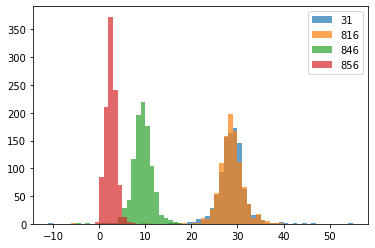

In [17]:
pm, mid = train_model(500,dropout = 0.1,id='sel')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 29
idx: 816 t: 44 p: 29
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 2


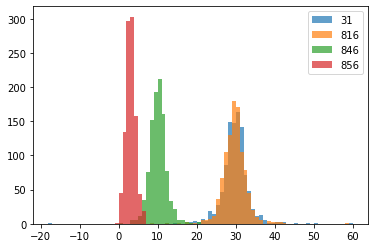

In [21]:
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 28
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 8
idx: 856 t: 4 p: 1


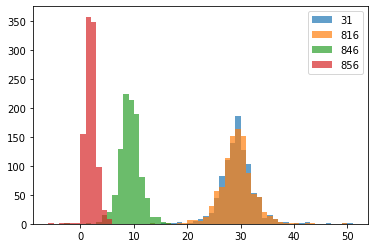

In [31]:
run_test(t[mid], s[mid], [31,816,846,856])

In [18]:
pitmodel = save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:45<00:00, 212.76it/s]


{
    "MSE": 2.170506532513962,
    "abs_error": 65189.56205482768,
    "abs_target_sum": 84410.26006088193,
    "abs_target_mean": 1.7620344444396605,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.307561021850031,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 42642.29159956571,
    "Coverage[0.1]": 0.7902515395052708,
    "QuantileLoss[0.5]": 65189.56205482768,
    "Coverage[0.5]": 0.9017847823817973,
    "QuantileLoss[0.9]": 24779.233726898732,
    "Coverage[0.9]": 0.9175242667779981,
    "RMSE": 1.4732639045717375,
    "NRMSE": 0.8361152696082771,
    "ND": 0.7722942922792668,
    "wQuantileLoss[0.1]": 0.5051790098598137,
    "wQuantileLoss[0.5]": 0.7722942922792668,
    "wQuantileLoss[0.9]": 0.2935571304842137,
    "mean_wQuantileLoss": 0.5236768108744314,
    "MAE_Coverage": 0.36985352955502204
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 167.80it/s, avg_epoch_loss=1.46]
INFO:root:Epoch[0] Elapsed time 0.598 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.459769
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 175.31it/s, avg_epoch_loss=1.16]
INFO:root:Epoch[1] Elapsed time 0.572 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.156980
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 177.78it/s, avg_epoch_loss=1.04]
INFO:root:Epoch[2] Elapsed time 0.564 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=1.044083
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 161.45it/s, avg_epoch_loss=0.999]
INFO:root:Epoch[3] Elapsed time 0.621 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.998903
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 174.63it/s,

INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 166.29it/s, avg_epoch_loss=0.886]
INFO:root:Epoch[72] Elapsed time 0.603 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.886178
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 176.96it/s, avg_epoch_loss=0.859]
INFO:root:Epoch[73] Elapsed time 0.567 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.858979
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 180.35it/s, avg_epoch_loss=0.842]
INFO:root:Epoch[74] Elapsed time 0.556 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.841856
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 179.64it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[75] Elapsed time 0.558 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.848252
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:00<00:00, 160.43it/s,

100%|██████████| 100/100 [00:00<00:00, 182.21it/s, avg_epoch_loss=0.846]
INFO:root:Epoch[144] Elapsed time 0.550 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=0.846030
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.43it/s, avg_epoch_loss=0.829]
INFO:root:Epoch[145] Elapsed time 0.565 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=0.829087
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.57it/s, avg_epoch_loss=0.856]
INFO:root:Epoch[146] Elapsed time 0.558 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=0.856435
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.09it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[147] Elapsed time 0.563 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=0.890187
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.51it/s, avg_epoch_loss=0.882]
INFO:root:Epoch[148] Ela

100%|██████████| 100/100 [00:00<00:00, 185.29it/s, avg_epoch_loss=0.845]
INFO:root:Epoch[216] Elapsed time 0.541 seconds
INFO:root:Epoch[216] Evaluation metric 'epoch_loss'=0.844898
INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.51it/s, avg_epoch_loss=0.875]
INFO:root:Epoch[217] Elapsed time 0.552 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=0.874910
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.61it/s, avg_epoch_loss=0.881]
INFO:root:Epoch[218] Elapsed time 0.546 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=0.880921
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 169.62it/s, avg_epoch_loss=0.852]
INFO:root:Epoch[219] Elapsed time 0.591 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=0.852101
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.42it/s, avg_epoch_loss=0.884]
INFO:root:Epoch[220] El

100%|██████████| 100/100 [00:00<00:00, 181.26it/s, avg_epoch_loss=0.861]
INFO:root:Epoch[288] Elapsed time 0.553 seconds
INFO:root:Epoch[288] Evaluation metric 'epoch_loss'=0.860981
INFO:root:Epoch[289] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.42it/s, avg_epoch_loss=0.89]
INFO:root:Epoch[289] Elapsed time 0.610 seconds
INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=0.889782
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.86it/s, avg_epoch_loss=0.868]
INFO:root:Epoch[290] Elapsed time 0.612 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=0.867584
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.31it/s, avg_epoch_loss=0.862]
INFO:root:Epoch[291] Elapsed time 0.610 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=0.862231
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.29it/s, avg_epoch_loss=0.822]
INFO:root:Epoch[292] Ela

100%|██████████| 100/100 [00:00<00:00, 178.27it/s, avg_epoch_loss=0.847]
INFO:root:Epoch[360] Elapsed time 0.562 seconds
INFO:root:Epoch[360] Evaluation metric 'epoch_loss'=0.846922
INFO:root:Epoch[361] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.848]
INFO:root:Epoch[361] Elapsed time 0.558 seconds
INFO:root:Epoch[361] Evaluation metric 'epoch_loss'=0.848332
INFO:root:Epoch[362] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.38it/s, avg_epoch_loss=0.839]
INFO:root:Epoch[362] Elapsed time 0.559 seconds
INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=0.838736
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.22it/s, avg_epoch_loss=0.832]
INFO:root:Epoch[363] Elapsed time 0.559 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=0.831727
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 175.27it/s, avg_epoch_loss=0.833]
INFO:root:Epoch[364] El

100%|██████████| 100/100 [00:00<00:00, 161.93it/s, avg_epoch_loss=0.831]
INFO:root:Epoch[432] Elapsed time 0.619 seconds
INFO:root:Epoch[432] Evaluation metric 'epoch_loss'=0.830536
INFO:root:Epoch[433] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.62it/s, avg_epoch_loss=0.825]
INFO:root:Epoch[433] Elapsed time 0.588 seconds
INFO:root:Epoch[433] Evaluation metric 'epoch_loss'=0.824616
INFO:root:Epoch[434] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.71it/s, avg_epoch_loss=0.82]
INFO:root:Epoch[434] Elapsed time 0.558 seconds
INFO:root:Epoch[434] Evaluation metric 'epoch_loss'=0.819503
INFO:root:Epoch[435] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 177.88it/s, avg_epoch_loss=0.865]
INFO:root:Epoch[435] Elapsed time 0.563 seconds
INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=0.864777
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.26it/s, avg_epoch_loss=0.874]
INFO:root:Epoch[436] Ela

{
    "MSE": 1.039188971481898,
    "abs_error": 3980.5667862393107,
    "abs_target_sum": 5031.092032168558,
    "abs_target_mean": 1.0225796813350727,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.1213061459566063,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1520.6758291516526,
    "Coverage[0.1]": 0.10752032520325203,
    "QuantileLoss[0.5]": 3980.5667862393107,
    "Coverage[0.5]": 0.2733739837398374,
    "QuantileLoss[0.9]": 1921.0672762691524,
    "Coverage[0.9]": 0.6359756097560976,
    "RMSE": 1.0194061857188714,
    "NRMSE": 0.9968965786489538,
    "ND": 0.7911933951491565,
    "wQuantileLoss[0.1]": 0.30225561755351027,
    "wQuantileLoss[0.5]": 0.7911933951491565,
    "wQuantileLoss[0.9]": 0.38183902500410283,
    "mean_wQuantileLoss": 0.49176267923558986,
    "MAE_Coverage": 0.16605691056910568
}
mae =  7.400609756097561
idx: 31 t: 18 p: 23
idx: 816 t: 20 p: 10
idx: 846 t: 21 p: 16
idx: 856 t: 11 p: 8
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.06it/s]


{
    "MSE": 0.37917199785837763,
    "abs_error": 24063.23176426623,
    "abs_target_sum": 77647.07225634674,
    "abs_target_mean": 1.6208552814183643,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.39190953368788845,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 5534.42109281975,
    "Coverage[0.1]": 0.36827053543471455,
    "QuantileLoss[0.5]": 24063.23176426623,
    "Coverage[0.5]": 0.7598998016908465,
    "QuantileLoss[0.9]": 13768.186262890615,
    "Coverage[0.9]": 0.8316459659743242,
    "RMSE": 0.6157694356318586,
    "NRMSE": 0.3799040190022494,
    "ND": 0.3099052039569894,
    "wQuantileLoss[0.1]": 0.07127662295557287,
    "wQuantileLoss[0.5]": 0.3099052039569894,
    "wQuantileLoss[0.9]": 0.17731751967976134,
    "mean_wQuantileLoss": 0.18616644886410785,
    "MAE_Coverage": 0.1988414570504123
}
save model pitmodel-m65-mlp-dall-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


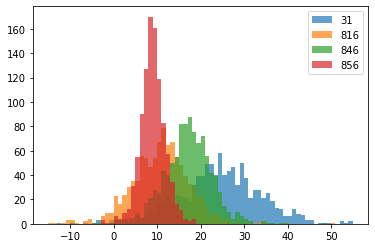

In [32]:
### run train on all data
trainset, testset, train_ds, test_ds, scaler = _data['all']

pm, mid = train_model(500,dropout = 0.1,id='all')
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, 'all', maxgap=65)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 151.64it/s, avg_epoch_loss=1.47]
INFO:root:Epoch[0] Elapsed time 0.661 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.469403
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 157.18it/s, avg_epoch_loss=1.14]
INFO:root:Epoch[1] Elapsed time 0.638 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.137794
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.69it/s, avg_epoch_loss=0.915]
INFO:root:Epoch[2] Elapsed time 0.648 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.914556
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 169.43it/s, avg_epoch_loss=0.871]
INFO:root:Epoch[3] Elapsed time 0.592 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.870562
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 172.33it/s

INFO:root:Epoch[72] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 175.61it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[72] Elapsed time 0.571 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=0.718308
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 177.85it/s, avg_epoch_loss=0.681]
INFO:root:Epoch[73] Elapsed time 0.564 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=0.681050
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 179.53it/s, avg_epoch_loss=0.733]
INFO:root:Epoch[74] Elapsed time 0.558 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=0.732549
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 174.43it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[75] Elapsed time 0.575 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=0.738408
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:00<00:00, 178.53it/s,

100%|██████████| 100/100 [00:00<00:00, 181.94it/s, avg_epoch_loss=0.74]
INFO:root:Epoch[108] Elapsed time 0.551 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=0.740352
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 179.20it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[109] Elapsed time 0.559 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=0.704802
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 181.39it/s, avg_epoch_loss=0.687]
INFO:root:Epoch[110] Elapsed time 0.553 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=0.686689
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 176.09it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[111] Elapsed time 0.570 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=0.712036
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.99it/s, avg_epoch_loss=0.724]
INFO:root:Epoch[112] Ela

100%|██████████| 100/100 [00:00<00:00, 179.78it/s, avg_epoch_loss=0.728]
INFO:root:Epoch[180] Elapsed time 0.558 seconds
INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=0.727965
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.58it/s, avg_epoch_loss=0.731]
INFO:root:Epoch[181] Elapsed time 0.544 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=0.730786
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 183.39it/s, avg_epoch_loss=0.735]
INFO:root:Epoch[182] Elapsed time 0.547 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=0.735243
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 164.64it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[183] Elapsed time 0.610 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=0.718372
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.66it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[184] El

100%|██████████| 100/100 [00:00<00:00, 179.66it/s, avg_epoch_loss=0.702]
INFO:root:Epoch[252] Elapsed time 0.558 seconds
INFO:root:Epoch[252] Evaluation metric 'epoch_loss'=0.702363
INFO:root:Epoch[253] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 185.64it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[253] Elapsed time 0.540 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=0.705442
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 182.54it/s, avg_epoch_loss=0.706]
INFO:root:Epoch[254] Elapsed time 0.549 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=0.705993
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 163.40it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[255] Elapsed time 0.614 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=0.717514
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.91it/s, avg_epoch_loss=0.738]
INFO:root:Epoch[256] El

100%|██████████| 100/100 [00:00<00:00, 161.74it/s, avg_epoch_loss=0.68]
INFO:root:Epoch[324] Elapsed time 0.620 seconds
INFO:root:Epoch[324] Evaluation metric 'epoch_loss'=0.679599
INFO:root:Epoch[325] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 171.95it/s, avg_epoch_loss=0.693]
INFO:root:Epoch[325] Elapsed time 0.583 seconds
INFO:root:Epoch[325] Evaluation metric 'epoch_loss'=0.692864
INFO:root:Epoch[326] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 172.70it/s, avg_epoch_loss=0.701]
INFO:root:Epoch[326] Elapsed time 0.580 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=0.701017
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 184.78it/s, avg_epoch_loss=0.712]
INFO:root:Epoch[327] Elapsed time 0.542 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=0.711806
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 178.88it/s, avg_epoch_loss=0.705]
INFO:root:Epoch[328] Ela

100%|██████████| 100/100 [00:00<00:00, 179.21it/s, avg_epoch_loss=0.72]
INFO:root:Epoch[396] Elapsed time 0.559 seconds
INFO:root:Epoch[396] Evaluation metric 'epoch_loss'=0.719797
INFO:root:Epoch[397] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 170.72it/s, avg_epoch_loss=0.718]
INFO:root:Epoch[397] Elapsed time 0.587 seconds
INFO:root:Epoch[397] Evaluation metric 'epoch_loss'=0.717534
INFO:root:Epoch[398] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 151.13it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[398] Elapsed time 0.663 seconds
INFO:root:Epoch[398] Evaluation metric 'epoch_loss'=0.688146
INFO:root:Epoch[399] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 173.50it/s, avg_epoch_loss=0.682]
INFO:root:Epoch[399] Elapsed time 0.578 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=0.681879
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 180.05it/s, avg_epoch_loss=0.716]
INFO:root:Epoch[400] Ela

100%|██████████| 100/100 [00:00<00:00, 193.94it/s, avg_epoch_loss=0.719]
INFO:root:Epoch[468] Elapsed time 0.517 seconds
INFO:root:Epoch[468] Evaluation metric 'epoch_loss'=0.719060
INFO:root:Epoch[469] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.86it/s, avg_epoch_loss=0.692]
INFO:root:Epoch[469] Elapsed time 0.523 seconds
INFO:root:Epoch[469] Evaluation metric 'epoch_loss'=0.692263
INFO:root:Epoch[470] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 192.75it/s, avg_epoch_loss=0.707]
INFO:root:Epoch[470] Elapsed time 0.520 seconds
INFO:root:Epoch[470] Evaluation metric 'epoch_loss'=0.707448
INFO:root:Epoch[471] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.76it/s, avg_epoch_loss=0.732]
INFO:root:Epoch[471] Elapsed time 0.523 seconds
INFO:root:Epoch[471] Evaluation metric 'epoch_loss'=0.731722
INFO:root:Epoch[472] Learning rate is 5e-05
100%|██████████| 100/100 [00:00<00:00, 191.99it/s, avg_epoch_loss=0.679]
INFO:root:Epoch[472] El

{
    "MSE": 0.922615022583552,
    "abs_error": 3605.5270269594307,
    "abs_target_sum": 4883.632899466723,
    "abs_target_mean": 1.0253270836587702,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 1.0353874601944504,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 1409.861401869293,
    "Coverage[0.1]": 0.13667856393029604,
    "QuantileLoss[0.5]": 3605.5270269594307,
    "Coverage[0.5]": 0.262019735460844,
    "QuantileLoss[0.9]": 1969.5693903192528,
    "Coverage[0.9]": 0.5903842116313248,
    "RMSE": 0.9605285121138009,
    "NRMSE": 0.9368020482656689,
    "ND": 0.7382878896063508,
    "wQuantileLoss[0.1]": 0.2886911098545604,
    "wQuantileLoss[0.5]": 0.7382878896063508,
    "wQuantileLoss[0.9]": 0.4033000495459688,
    "mean_wQuantileLoss": 0.4767596830022934,
    "MAE_Coverage": 0.19475820561270907
}
mae =  6.912240184757506
idx: 31 t: 18 p: 25
idx: 816 t: 2 p: 2
idx: 846 t: 35 p: 15
idx: 856 t: 25 p: 6
make full testdb: 47905 records


Running evaluation: 100%|██████████| 47905/47905 [03:44<00:00, 213.33it/s]


{
    "MSE": 2.072099756308953,
    "abs_error": 58884.045941364646,
    "abs_target_sum": 80870.58516372032,
    "abs_target_mean": 1.6881449778461604,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.5440069127184829,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 18850.915041648448,
    "Coverage[0.1]": 0.05383571652228369,
    "QuantileLoss[0.5]": 58884.045941364646,
    "Coverage[0.5]": 0.18883206345892914,
    "QuantileLoss[0.9]": 53647.7137817443,
    "Coverage[0.9]": 0.3778519987475211,
    "RMSE": 1.4394789877969574,
    "NRMSE": 0.8526986761726671,
    "ND": 0.7281268686526193,
    "wQuantileLoss[0.1]": 0.2330997729704228,
    "wQuantileLoss[0.5]": 0.7281268686526193,
    "wQuantileLoss[0.9]": 0.6633773413798844,
    "mean_wQuantileLoss": 0.5415346610009756,
    "MAE_Coverage": 0.2931600737570887
}
save model pitmodel-m65-mlp-dnoshort-e500-l10-10-5-student-d0.1-1k-withcurcautionlaps.pickle with 47905 keys.


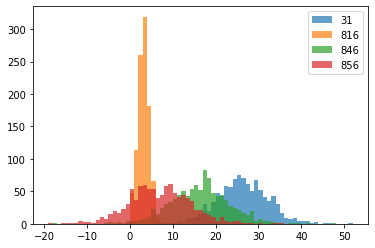

In [40]:
### run train on all data
tid = 'noshort'
trainset, testset, train_ds, test_ds, scaler = _data[tid]

pm, mid = train_model(500,dropout = 0.1,id=tid)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])
pitmodel = save_full_pitmodel(mid, tid, maxgap=65)

In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]

### shortterm predictions using pitmodel(plen=2)

convert forecast samples of pitmodel to forecast samples of pit@plen laps

In [18]:
test_car12 = df_test[df_test['carno']==12]

In [19]:
test_ds, _, test_set = makedb(test_car12[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

In [20]:
len(test_set)

170

In [21]:
test

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

In [23]:
test_car12[test_car12['lap']==31]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1059,18.0,0.0,0.0,1.0,12,5,31,18.0


In [24]:
test_car12[test_car12['lap']==30]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
1058,1.0,0.0,31.0,0.0,12,5,30,31.0


In [25]:
test_ds

[{'target': array([1.88149958]),
  'feat': array([-0.70945244, -1.40995345]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.76852039]),
  'feat': array([-0.70945244, -1.29736294]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.6555412]),
  'feat': array([-0.70945244, -1.18477243]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.54256201]),
  'feat': array([-0.70945244, -1.07218192]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target': array([1.42958282]),
  'feat': array([-0.70945244, -0.95959142]),
  'start': Timestamp('2019-01-01 00:00:00', freq='T'),
  'forecast_start': Timestamp('2019-01-01 00:00:00', freq='T')},
 {'target':

In [26]:
len(test_ds)

170

In [28]:
test_set

array([[ 1.88149958, -0.70945244, -1.40995345],
       [ 1.76852039, -0.70945244, -1.29736294],
       [ 1.6555412 , -0.70945244, -1.18477243],
       [ 1.54256201, -0.70945244, -1.07218192],
       [ 1.42958282, -0.70945244, -0.95959142],
       [ 1.31660363, -0.70945244, -0.84700091],
       [ 1.20362444, -0.70945244, -0.7344104 ],
       [ 1.09064525, -0.70945244, -0.62181989],
       [ 0.97766607, -0.70945244, -0.50922938],
       [ 0.86468688, -0.70945244, -0.39663887],
       [ 0.75170769, -0.70945244, -0.28404836],
       [ 0.6387285 , -0.70945244, -0.17145786],
       [ 0.52574931, -0.70945244, -0.05886735],
       [ 0.41277012, -0.70945244,  0.05372316],
       [ 0.29979093, -0.70945244,  0.16631367],
       [ 0.18681174, -0.70945244,  0.27890418],
       [ 0.07383255, -0.70945244,  0.39149469],
       [-0.03914664, -0.70945244,  0.5040852 ],
       [-0.15212582, -0.70945244,  0.6166757 ],
       [-0.26510501, -0.70945244,  0.72926621],
       [-0.3780842 , -0.70945244,  0.841

### test

In [19]:
df12 = df_test[(df_test['eid']==5) & (df_test['carno']==12)]

In [20]:
df12[(df12['lap']>=45) & (df12['lap']<55)]

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1073,4.0,0.0,14.0,1.0,12,5,45,18.0,0.0
1074,3.0,0.0,15.0,1.0,12,5,46,18.0,0.0
1075,2.0,1.0,16.0,1.0,12,5,47,18.0,1.0
1076,1.0,2.0,17.0,1.0,12,5,48,18.0,2.0
1077,44.0,0.0,0.0,0.0,12,5,49,44.0,0.0
1078,43.0,1.0,1.0,0.0,12,5,50,44.0,1.0
1079,42.0,2.0,2.0,0.0,12,5,51,44.0,2.0
1080,41.0,3.0,3.0,0.0,12,5,52,44.0,3.0
1081,40.0,4.0,4.0,0.0,12,5,53,44.0,4.0
1082,39.0,4.0,5.0,0.0,12,5,54,44.0,0.0


In [21]:
df12

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
1028,31.0,0.0,1.0,0.0,12,5,0,31.0,0.0
1029,30.0,0.0,2.0,0.0,12,5,1,31.0,0.0
1030,29.0,0.0,3.0,0.0,12,5,2,31.0,0.0
1031,28.0,0.0,4.0,0.0,12,5,3,31.0,0.0
1032,27.0,0.0,5.0,0.0,12,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
1193,5.0,20.0,37.0,0.0,12,5,165,42.0,0.0
1194,4.0,20.0,38.0,0.0,12,5,166,42.0,0.0
1195,3.0,20.0,39.0,0.0,12,5,167,42.0,0.0
1196,2.0,20.0,40.0,0.0,12,5,168,42.0,0.0


In [22]:
df12.cur_cautionlaps.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 1.,
       2., 3., 4., 0., 0., 0., 1., 2., 3., 4., 5., 0., 0., 0., 0., 0., 1.,
       2., 3., 4., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 3., 4., 5., 6., 0., 1., 2., 3., 4., 5., 6., 7., 0.,
       1., 2., 3., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
train_set

array([[ 1.56895685, -0.64173227, -1.57348481, -0.21381922],
       [ 1.24715782, -0.64173227, -1.68074602, -0.21381922],
       [ 0.60355976, -0.64173227, -0.60813392, -0.21381922],
       ...,
       [ 0.06722804,  1.35544334,  0.35721696, -0.21381922],
       [-0.89816905,  0.35685554,  0.67900059, -0.21381922],
       [-0.68363636,  3.01975635,  1.53709027, -0.21381922]])

In [33]:
samples = np.zeros((1000))
for i in range(1000):
    samples[i] = pitmodel.predict(1,16,1)
    
samples[samples<5]

array([4., 4., 2., 2., 4., 4., 4., 3., 4., 1., 2., 4., 2., 3., 3., 2., 2.,
       3., 4., 4., 1., 3., 2., 2., 3., 4., 2., 4., 3., 4., 4., 1., 4., 3.,
       1., 4., 1., 1., 2., 1., 3., 1., 4., 2., 4., 3., 4., 2., 3., 4., 4.,
       2., 2., 1., 4., 2., 3., 3., 2., 2., 2., 4., 4., 4., 4., 1., 1., 3.,
       2., 2., 4., 4., 2., 1., 2., 1., 2., 3., 1., 3., 2., 2., 4., 2., 2.,
       1., 2., 4., 4., 2., 1., 4., 4., 2., 2., 1., 4., 4., 2., 3., 4., 4.,
       3., 3., 1., 3., 4., 4., 2., 2., 3., 4., 4., 3., 4.])

In [34]:
np.sum(samples<5)

115

In [35]:
np.min(samples)

1.0

In [36]:
np.max(samples)

39.0

In [34]:
test_all

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0


In [35]:
df_test

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len,cur_cautionlaps
0,31.0,0.0,1.0,0.0,1,5,0,31.0,0.0
1,30.0,0.0,2.0,0.0,1,5,1,31.0,0.0
2,29.0,0.0,3.0,0.0,1,5,2,31.0,0.0
3,28.0,0.0,4.0,0.0,1,5,3,31.0,0.0
4,27.0,0.0,5.0,0.0,1,5,4,31.0,0.0
...,...,...,...,...,...,...,...,...,...
5566,999.0,5.0,26.0,0.0,98,5,195,0.0,0.0
5567,999.0,5.0,27.0,0.0,98,5,196,0.0,0.0
5568,999.0,5.0,28.0,0.0,98,5,197,0.0,0.0
5569,999.0,5.0,29.0,0.0,98,5,198,0.0,0.0
